Adapted from [ner_with_bilstm_and_crf](https://www.kaggle.com/nikkisharma536/ner-with-bilstm-and-crf/notebook)
Altigran Soares da Silva
IComp/UFAM - 15/03/2021


In [ ]:
# For this to work, use:
# Keras 2.3.1
# TensorFlow 1.15.2
# Also remember to use GPU in your colab notebook
%tensorflow_version 1.x

# Code to read csv file into Colaboratory:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

from math import nan
from future.utils import iteritems
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import json
import pickle
import time
from requests import get

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch import cuda
from torch.utils.data import Dataset, DataLoader

!pip install sentencepiece
!pip install transformers
from transformers import BertForTokenClassification, AutoTokenizer

!pip install seqeval
from seqeval.metrics import f1_score, classification_report

TensorFlow 1.x selected.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Code to read csv file from google drive into Colaboratory:
DATA_TRAINING_FILE_ID = '1Y2gfhNgbGX7pA0FkA2vbOxdoSmNJVHIK'
DATA_TRAINING_FILENAME = 'ner_training_dataset.csv'
DATA_DEV_FILE_ID = '1AGW9cRPwBmeJqOo3WXPPcNckrX4jMcIn'
DATA_DEV_FILENAME = 'ner_validation_dataset.csv'
DATA_TEST_FILE_ID = '1L-fnx31bK0nZAl9_DDfo7-25H7PYU0l8'
DATA_TEST_FILENAME = 'ner_test_dataset.csv'
BACKUP_FOLDER_ID = '1YWR4Ip8w94RwFMyMtNpRa9M0FpiJtqd5'

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
downloaded_training = drive.CreateFile({'id': DATA_TRAINING_FILE_ID})
downloaded_training.GetContentFile(DATA_TRAINING_FILENAME)
downloaded_dev = drive.CreateFile({'id': DATA_DEV_FILE_ID})
downloaded_dev.GetContentFile(DATA_DEV_FILENAME)
downloaded_test = drive.CreateFile({'id': DATA_TEST_FILE_ID})
downloaded_test.GetContentFile(DATA_TEST_FILENAME)

# Read the csv file in a dataframe called "data"
training_data = pd.read_csv(DATA_TRAINING_FILENAME, encoding="latin1")
dev_data = pd.read_csv(DATA_DEV_FILENAME, encoding="latin1")
test_data = pd.read_csv(DATA_TEST_FILENAME, encoding="latin1")
# Fill NaN values using the specified method
# Ffill propagate last valid observation/value forward to next valid 
training_data = training_data.fillna(method="ffill")
dev_data = dev_data.fillna(method="ffill")
test_data = test_data.fillna(method="ffill")

notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']

In [ ]:
# Explore the input dataset
print("Number of training sentences: ", len(training_data.groupby(['Sentence #'])))
print("Number of dev sentences: ", len(dev_data.groupby(['Sentence #'])))
print("Number of test sentences: ", len(test_data.groupby(['Sentence #'])))

training_words = list(set(training_data["Word"].values))
n_training_words = len(training_words)
print("Number of words in the training dataset: ", n_training_words)
dev_words = list(set(dev_data["Word"].values))
n_dev_words = len(dev_words)
print("Number of words in the dev dataset: ", n_dev_words)
test_words = list(set(test_data["Word"].values))
n_test_words = len(test_words)
print("Number of words in the test dataset: ", n_test_words)

training_tags = list(set(training_data["Tag"].values))
print("Tags in the training dataset:", training_tags)
n_training_tags = len(training_tags)
print("Number of Labels in the training dataset: ", n_training_tags)
dev_tags = list(set(dev_data["Tag"].values))
print("Tags in the dev dataset:", dev_tags)
n_dev_tags = len(dev_tags)
print("Number of Labels in the dev dataset: ", n_dev_tags)
test_tags = list(set(test_data["Tag"].values))
print("Tags in the test dataset:", test_tags)
n_test_tags = len(test_tags)
print("Number of Labels in the test dataset: ", n_test_tags)

print("What the training dataset looks like:")
# Show the first 10 rows
training_data.head(n=10)

Number of training sentences:  13052
Number of dev sentences:  3263
Number of test sentences:  27625
Number of words in the training dataset:  13860
Number of words in the dev dataset:  6360
Number of words in the test dataset:  21696
Tags in the training dataset: ['B-treatment', 'I-problem', 'I-test', 'O', 'B-problem', 'B-test', 'I-treatment']
Number of Labels in the training dataset:  7
Tags in the dev dataset: ['B-treatment', 'I-problem', 'I-test', 'O', 'B-problem', 'B-test', 'I-treatment']
Number of Labels in the dev dataset:  7
Tags in the test dataset: ['I-problem', 'B-treatment', 'I-test', 'O', 'B-problem', 'B-test', 'I-treatment']
Number of Labels in the test dataset:  7
What the training dataset looks like:


,Sentence #,Word,Tag
0,Sentence: 10707,She,O
1,Sentence: 10707,had,O
2,Sentence: 10707,normal,O
3,Sentence: 10707,comprehension,O
4,Sentence: 10707,.,O
5,Sentence: 7349,Scott,O
6,Sentence: 7349,Robert,O
7,Sentence: 7349,NP,O
8,Sentence: 7349,80-AUM,O
9,Sentence: 7349,2017-06-29,O


In [ ]:
# SentenceGetter re-organize "data" as an arry of sentences
# Each sentence is a list of pairs <word,tag> 
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w,t in zip(s["Word"].values.tolist(),
                                                        s["Tag"].values.tolist())]
        self.grouped = self.dataset.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

training_getter = SentenceGetter(training_data)
training_sentences = training_getter.sentences
dev_getter = SentenceGetter(dev_data)
dev_sentences = dev_getter.sentences
test_getter = SentenceGetter(test_data)
test_sentences = test_getter.sentences

# Example: training sentence #200 
training_sentences[200]

[('Last', 'O'),
 ('menstrual', 'O'),
 ('period', 'O'),
 ('2009-02-21', 'O'),
 ('.', 'O')]

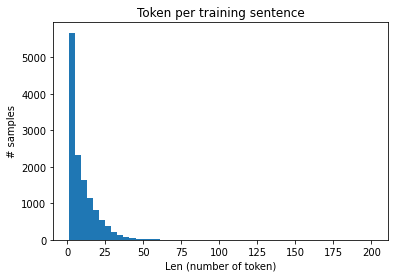

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in training_sentences], bins=50)
plt.title('Token per training sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

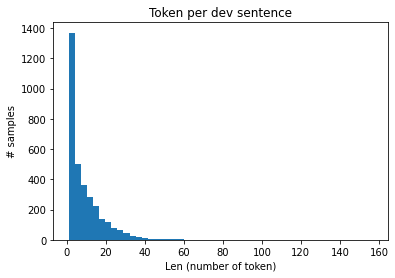

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in dev_sentences], bins=50)
plt.title('Token per dev sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

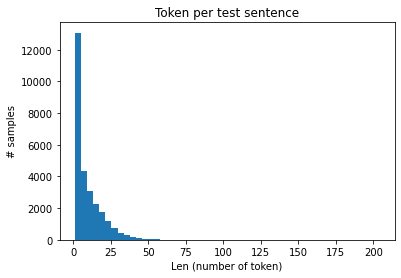

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in test_sentences], bins=50)
plt.title('Token per test sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

In [ ]:
# Keras (and most other ML packages) expect all the ids to be numeric, 
# this is an optimisation to save memory. 
# We will create the following dictionaries:
# word2idx: assign a numeric index to each word in the dataset
# idx2word: inverted version of word2idx
# tag2idx: assign a numeric index to each tag in the dataset
# idx2tag: inverted version of tag2idx

# Group training, dev and test data in order to create word-index dicts and to
# convert data to numeric indeces later
data = pd.concat([training_data, dev_data, test_data])

# words <= list of all words in the input dataset
words = list(set(data["Word"].values))
n_words = len(words)

# tags <= list of all tags in the input dataset
tags = []
for tag in set(data["Tag"].values):
    if tag is nan or isinstance(tag, float):
        tags.append('unk')
    else:
        tags.append(tag)
n_tags = len(tags)

# Dictionaries
word2idx = {w: i for i, w in enumerate(words)}
idx2word = {i: w for w, i in iteritems(word2idx)}
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {v: k for k, v in iteritems(tag2idx)}

# Index number for the word 'comprehension'
print(word2idx['comprehension'])
# Word of index 10
print(idx2word[10])
# Index number for the tag 'B-treatment'
print(tag2idx['B-treatment'])
# Tag of index 4
print(idx2tag[4])

610
Atraumatic
0
B-problem


In [ ]:
# Convert train, dev and test data to numeric values
X_train = [[word2idx[w[0]] for w in s] for s in training_sentences]
y_train = [[tag2idx[w[1]] for w in s] for s in training_sentences]

X_dev = [[word2idx[w[0]] for w in s] for s in dev_sentences]
y_dev = [[tag2idx[w[1]] for w in s] for s in dev_sentences]

X_test = [[word2idx[w[0]] for w in s] for s in test_sentences]
y_test = [[tag2idx[w[1]] for w in s] for s in test_sentences]

In [ ]:
# Use this function to randomly remove some points from training dataset
# Use removal percentage in decimal value. E.g.: if you set as 0.5, it will
# remove 50% of the dataset

def random_remove_data_points(dataset, labels, removal_percentage):
    if removal_percentage < 0 or removal_percentage > 1:
        raise Exception("Invalid removal percentage")
    
    if removal_percentage == 1:
        raise Exception("You can't remove the entire dataset")
    
    number_of_points_remaining = round(len(dataset)*(1-removal_percentage))

    try_again = True

    while try_again:
      random_idxs = np.random.choice(len(dataset), number_of_points_remaining, replace=False)
      cut_dataset_sentences = [dataset[i] for i in random_idxs]
      cut_dataset_labels = [labels[i] for i in random_idxs]
      cut_tags = list(set([idx2tag[j] for sub in cut_dataset_labels for j in sub]))

      if all(i in cut_tags for i in tags if i[:2] == "B-"):
        try_again = False

    return cut_dataset_sentences, cut_dataset_labels 

print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")
X_train, y_train = random_remove_data_points(X_train, y_train, 0.25)
print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")

Points in X_train before removal: 13052
Points in y_train before removal: 13052
Points in X_train before removal: 9789
Points in y_train before removal: 9789


In [ ]:
# Aux functions to save data and dicts, if data consistency is important
# and there is desire to not random split again

def save_backup_dataset(dataset, filename):
  dataset_df = pd.DataFrame(dataset)
  dataset_df.to_csv(filename, index=False)
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

def save_backup_dict(dict, filename):
  dict_file = open(filename, "wb")
  pickle.dump(dict, dict_file)
  dict_file.close()
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

In [ ]:
# Uncomment this cell if you want to save data for further use

# Check some points before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['comprehension'])
print(tag2idx['B-treatment'])
print(idx2tag[2])
print(idx2word[100])
print(n_words)
print(n_tags)

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

save_backup_dataset(X_train, X_train_filename)
save_backup_dataset(y_train, y_train_filename)
save_backup_dataset(X_dev, X_dev_filename)
save_backup_dataset(y_dev, y_dev_filename)
save_backup_dataset(X_test, X_test_filename)
save_backup_dataset(y_test, y_test_filename)

save_backup_dict(word2idx, word2idx_filename)
save_backup_dict(idx2word, idx2word_filename)
save_backup_dict(tag2idx, tag2idx_filename)
save_backup_dict(idx2tag, idx2tag_filename)

save_backup_dict({"n_words":n_words, "n_tags":n_tags}, others_filename)

[16588]
[3]
[4144, 13005, 14150, 18634, 23034, 12124, 17707, 23032, 17634, 18305, 14026, 10291, 17439, 20455]
[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
[18572, 23037, 12586]
[3, 3, 3]
610
0
I-test
Aerobid
28388
7


In [1]:
# Uncomment this cell if you want to load saved data

# Re-import necessary libs
import pandas as pd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pickle, math
from requests import get
import numpy as np
import matplotlib.pyplot as plt
import random
import time
%tensorflow_version 1.x
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch import cuda
from torch.utils.data import Dataset, DataLoader
!pip install sentencepiece
!pip install transformers
from transformers import BertForTokenClassification, AutoTokenizer
import matplotlib.pyplot as plt
!pip install seqeval
from seqeval.metrics import f1_score, classification_report

BACKUP_FOLDER_ID = '1YWR4Ip8w94RwFMyMtNpRa9M0FpiJtqd5'
notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

# Re-get important variables
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def get_backup_files_ids(folder_id):
  file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format(folder_id)}).GetList()
  return file_list

def load_backup_dataset(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.csv")

  dataset = pd.read_csv(f"{file_id}.csv", encoding="latin1")
  dataset = dataset.fillna(method="ffill")
  dataset = dataset.values.tolist()
  dataset = [ [ int(word) for word in sentence if str(word) != 'nan' ] for sentence in dataset]
  return dataset

def load_backup_dict(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.pkl")

  dict_file = open(f"{file_id}.pkl", "rb")
  out_dict = pickle.load(dict_file)
  return out_dict

backup_file_list = get_backup_files_ids(BACKUP_FOLDER_ID)

X_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_train_filename][0]['id']
y_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_train_filename][0]['id']
X_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_dev_filename][0]['id']
y_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_dev_filename][0]['id']
X_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_test_filename][0]['id']
y_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_test_filename][0]['id']

word2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == word2idx_filename][0]['id']
idx2word_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2word_filename][0]['id']
tag2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == tag2idx_filename][0]['id']
idx2tag_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2tag_filename][0]['id']

others_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == others_filename][0]['id']

X_train = load_backup_dataset(X_train_file_id)
y_train = load_backup_dataset(y_train_file_id)
X_dev = load_backup_dataset(X_dev_file_id)
y_dev = load_backup_dataset(y_dev_file_id)
X_test = load_backup_dataset(X_test_file_id)
y_test = load_backup_dataset(y_test_file_id)

word2idx = load_backup_dict(word2idx_file_id)
idx2word = load_backup_dict(idx2word_file_id)
tag2idx = load_backup_dict(tag2idx_file_id)
idx2tag = load_backup_dict(idx2tag_file_id)

others = load_backup_dict(others_file_id)

n_words = others["n_words"]
n_tags = others["n_tags"]

# Check some points after loading data to see if they match the ones before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['comprehension'])
print(tag2idx['B-treatment'])
print(idx2tag[2])
print(idx2word[100])
print(n_words)
print(n_tags)

After that, `%tensorflow_version 1.x` will throw an error.

Your notebook should be updated to use Tensorflow 2.
See the guide at https://www.tensorflow.org/guide/migrate#migrate-from-tensorflow-1x-to-tensorflow-2.

TensorFlow 1.x selected.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 15.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 14.6 MB/s 
     |████████████████████████████████| 596 kB 86.9 MB/s 
     |████████████████████████████████| 6.6 MB 83.5 MB/s 
     |████████████████████████████████| 101 kB 14.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 2.3 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=4a620a32aca2c6bdb6541b240750f224bad9012bb19c95daef0eca50eeafa6c8
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval
[16588]
[3]
[4144, 13005, 14150, 18634, 23034, 12124, 17707, 23032, 17634, 18305, 14026, 10291, 17439, 20455]
[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
[18572, 23037, 12586]
[3, 3, 3]
610
0
I-test
Aerobid
28388
7


In [2]:
# Aux function to help in augmentation. Generates a dict where entities
# are the keys, and words are the values.

def create_entities_dict(dataset, labels, decoded_word=False):
    entities_dict = {}
    
    for i, sentence in enumerate(dataset):
        for k, word in enumerate(sentence):
            tag = idx2tag[labels[i][k]]
            if tag[:2] == "B-":
                if decoded_word:
                    word_list = [idx2word[word]]
                else:
                    word_list = [word]
                j = k + 1
                if j < len(labels[i]):
                    while idx2tag[labels[i][j]][:2] == "I-":
                        if decoded_word:
                            word_list.append(idx2word[dataset[i][j]])
                        else:
                            word_list.append(dataset[i][j])
                        j = j+1
                        if j == len(labels[i]):
                            break
                        
                if entities_dict.get(tag):
                    if word_list not in entities_dict[tag]:
                        entities_dict[tag].append(word_list)
                else:
                    entities_dict[tag] = [word_list]
                    
    return entities_dict

entities_dict = create_entities_dict(X_train, y_train)

In [3]:
# Augmentation function using entity replacement technique.
# It will generate a new dataset, with X% more points based on
# the original dataset. E.g.: if you set augmentation percentage as 0.5 and dataset has
# 1000 points, it will generate a dataset with 1500 points.

def generate_sentences(dataset, labels, entities_dict, augmented_set_size_percentage):
    if augmented_set_size_percentage < 0:
        raise Exception("Invalid augmented set size percentage")

    number_of_new_sentences = math.ceil(augmented_set_size_percentage * len(dataset))
    random_idxs = np.random.choice(len(dataset), number_of_new_sentences, replace=True)
    
    base_sequences = [dataset[i] for i in random_idxs]
    base_labels = [labels[i] for i in random_idxs]

    new_sequences = []
    new_labels = []
    
    for k, sequence in enumerate(base_sequences):
        new_sequence = []
        new_label = []

        for i, word in enumerate(sequence):
            tag = idx2tag[base_labels[k][i]]
            if tag == "O":
                new_sequence.append(word)
                new_label.append(base_labels[k][i])
            elif tag[:2] == "B-":
                same_entities_type_tmp = entities_dict[tag]
                same_entities_type = np.array(same_entities_type_tmp, dtype=object)
                random_entity_idx = np.random.choice(len(same_entities_type), 1)[0]
                random_entity = same_entities_type[random_entity_idx]
                random_number_of_tokens = random.randint(1, len(random_entity))
                random_entity_tokens = np.random.choice(random_entity, random_number_of_tokens, replace = False).tolist()
                entity = tag[2:]
                decoded_token_labels = [f"I-{entity}" for token in random_entity_tokens]
                decoded_token_labels[0] = tag
                encoded_token_labels = [tag2idx[label] for label in decoded_token_labels]
                new_sequence = new_sequence + random_entity_tokens
                new_label = new_label + encoded_token_labels

        new_sequences.append(new_sequence)
        new_labels.append(new_label)

    augmented_X_train = dataset + new_sequences
    augmented_y_train = labels + new_labels

    print(f"Points in X_train after augmentation: {len(augmented_X_train)}")
    print(f"Points in y_train after augmentation: {len(augmented_y_train)}")

    return augmented_X_train, augmented_y_train

In [4]:
tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")

class dataset(Dataset):
  def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

  def __getitem__(self, index):
        # step 1: get the sentence and word labels
        sentence = self.data.sentence[index]
        word_labels = self.data.word_labels[index].split(",") 

        # step 2: use tokenizer to encode sentence (includes padding/truncation up to max length)
        # BertTokenizerFast provides a handy "return_offsets_mapping" functionality for individual tokens
        encoding = self.tokenizer(sentence,
                             return_offsets_mapping=True, 
                             padding='max_length', 
                             truncation=True, 
                             max_length=self.max_len)
        
        # step 3: create token labels only for first word pieces of each tokenized word
        labels = [tag2idx[label] for label in word_labels] 
        # code based on https://huggingface.co/transformers/custom_datasets.html#tok-ner
        # create an empty array of -100 of length max_length
        encoded_labels = np.ones(len(encoding["offset_mapping"]), dtype=int) * -100
        
        # set only labels whose first offset position is 0 and the second is not 0
        i = 0
        for idx, mapping in enumerate(encoding["offset_mapping"]):
          if mapping[0] == 0 and mapping[1] != 0:
            # overwrite label
            encoded_labels[idx] = labels[i]
            i += 1

        # step 4: turn everything into PyTorch tensors
        item = {key: torch.as_tensor(val) for key, val in encoding.items()}
        item['labels'] = torch.as_tensor(encoded_labels)
        
        return item

  def __len__(self):
        return self.len

Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/223k [00:00<?, ?B/s]

In [5]:
# some configuration variables
LEARNING_RATE = 5e-05
MAX_GRAD_NORM = 10
TRAINING_STOP_LOSS_PERCENTAGE = 1

# Model creation function
def create_model(maxlen, n_labels, training_set, testing_set, validation_set):
  device = 'cuda' if cuda.is_available() else 'cpu'
  print("Device: ", device)

  model = BertForTokenClassification.from_pretrained('allenai/scibert_scivocab_uncased', num_labels=n_labels)
  model.to(device)

  optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

  TRAIN_BATCH_SIZE = round(0.05*len(training_set))
  if TRAIN_BATCH_SIZE > 64:
    TRAIN_BATCH_SIZE = 64
  if TRAIN_BATCH_SIZE < 10:
    TRAIN_BATCH_SIZE = 10

  VALID_BATCH_SIZE = round(0.1*len(validation_set))
  if VALID_BATCH_SIZE > 64:
    VALID_BATCH_SIZE = 64
  if VALID_BATCH_SIZE < 10:
    VALID_BATCH_SIZE = 10

  train_params = {'batch_size': TRAIN_BATCH_SIZE,
                  'shuffle': True,
                  'num_workers': 0
                  }

  test_params = {'batch_size': VALID_BATCH_SIZE,
                  'shuffle': True,
                  'num_workers': 0
                  }

  training_loader = DataLoader(training_set, **train_params)
  testing_loader = DataLoader(testing_set, **test_params)
  validation_loader = DataLoader(validation_set, **test_params)

  return model, device, optimizer, training_loader, testing_loader, validation_loader

In [6]:
# Model training function
def train(model, device, optimizer, training_loader, epoch, training_stop_loss_percentage):
    tr_loss, tr_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_preds, tr_labels = [], []
    losses = []
    # put model in training mode
    model.train()
    
    for idx, batch in enumerate(training_loader):
        
        ids = batch['input_ids'].to(device, dtype = torch.long)
        mask = batch['attention_mask'].to(device, dtype = torch.long)
        labels = batch['labels'].to(device, dtype = torch.long)

        loss, tr_logits = model(input_ids=ids, attention_mask=mask, labels=labels, return_dict = False)
        tr_loss += loss.item()

        nb_tr_steps += 1
        nb_tr_examples += labels.size(0)
        
        if idx % 100==0:
            loss_step = tr_loss/nb_tr_steps
            print(f"Training loss per 100 training steps: {loss_step}")
            losses.append(loss_step)
            last_5_losses = losses[-5:]
            loss_min = min(last_5_losses)
            loss_max = max(last_5_losses)
            if len(last_5_losses) > 1 and (loss_max - loss_min)/loss_max < training_stop_loss_percentage/100:
              print("Stopping epoch...")
              break
           
        # compute training accuracy
        flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
        active_logits = tr_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
        flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
        
        # only compute accuracy at active labels
        active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        #active_labels = torch.where(active_accuracy, labels.view(-1), torch.tensor(-100).type_as(labels))
        
        labels = torch.masked_select(flattened_targets, active_accuracy)
        predictions = torch.masked_select(flattened_predictions, active_accuracy)
        
        tr_labels.extend(labels)
        tr_preds.extend(predictions)

        tmp_tr_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
        tr_accuracy += tmp_tr_accuracy
    
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=MAX_GRAD_NORM
        )
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = tr_loss / nb_tr_steps
    tr_accuracy = tr_accuracy / nb_tr_steps
    print(f"Training loss epoch: {epoch_loss}")
    print(f"Training accuracy epoch: {tr_accuracy}")

In [7]:
# Model testing function
def test(model, device, testing_loader):
    print("Validating model...")
    # put model in evaluation mode
    model.eval()
    
    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []
    
    with torch.no_grad():
        for idx, batch in enumerate(testing_loader):
            
            ids = batch['input_ids'].to(device, dtype = torch.long)
            mask = batch['attention_mask'].to(device, dtype = torch.long)
            labels = batch['labels'].to(device, dtype = torch.long)
            
            loss, eval_logits = model(input_ids=ids, attention_mask=mask, labels=labels, return_dict = False)
            
            eval_loss += loss.item()

            nb_eval_steps += 1
            nb_eval_examples += labels.size(0)
        
            # compute evaluation accuracy
            flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
            active_logits = eval_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
            
            # only compute accuracy at active labels
            active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        
            labels = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)
            
            eval_labels.extend(labels)
            eval_preds.extend(predictions)
            
            tmp_eval_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
            eval_accuracy += tmp_eval_accuracy

    labels = [idx2tag[id.item()] for id in eval_labels]
    predictions = [idx2tag[id.item()] for id in eval_preds]
    
    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps
    print(f"Validation Loss: {eval_loss}")
    print(f"Validation Accuracy: {eval_accuracy}")

    return labels, predictions, eval_loss

In [8]:
def create_train_and_validate_model(augmented_percentage):

  augmented_X_train, augmented_y_train = generate_sentences(X_train, y_train, entities_dict, augmented_percentage)

  maxlen_X_train = max([len(s) for s in augmented_X_train])
  maxlen_X_test = max([len(s) for s in X_test])
  maxlen_X_dev = max([len(s) for s in X_dev])
  maxlen_y_train = max([len(s) for s in augmented_y_train])
  maxlen_y_test = max([len(s) for s in y_test])
  maxlen_y_dev = max([len(s) for s in y_dev])

  maxlen = max([maxlen_X_train, maxlen_X_test, maxlen_X_dev, maxlen_y_train, maxlen_y_test, maxlen_y_dev])

  augmented_X_train_words = [' '.join([idx2word[word] for word in sentence]) for sentence in augmented_X_train]
  X_dev_words = [' '.join([idx2word[word] for word in sentence]) for sentence in X_dev]
  X_test_words = [' '.join([idx2word[word] for word in sentence]) for sentence in X_test]
  augmented_y_train_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in augmented_y_train]
  y_dev_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in y_dev]
  y_test_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in y_test]

  new_train_df = pd.DataFrame({"sentence": augmented_X_train_words, "word_labels": augmented_y_train_tags}).reset_index(drop=True)
  new_test_df = pd.DataFrame({"sentence": X_test_words, "word_labels": y_test_tags}).reset_index(drop=True)
  new_val_df = pd.DataFrame({"sentence": X_dev_words, "word_labels": y_dev_tags}).reset_index(drop=True)

  training_set = dataset(new_train_df, tokenizer, maxlen)
  testing_set = dataset(new_test_df, tokenizer, maxlen)
  validation_set = dataset(new_val_df, tokenizer, maxlen)

  model, device, optimizer, training_loader, testing_loader, val_loader = create_model(maxlen, len(tag2idx), training_set, testing_set, validation_set)

  training_start_time = time.clock()
  min_val_loss = 0
  MAX_PATIENCE = 5
  patience = 0

  for epoch in range(100):
    print(f"Training epoch: {epoch + 1}")
    if patience == MAX_PATIENCE:
      print("Patience limit reached")
      break
    train(model, device, optimizer, training_loader, epoch, TRAINING_STOP_LOSS_PERCENTAGE)
    labels, predictions, val_loss = test(model, device, val_loader)
    if ((min_val_loss == 0) or (min_val_loss != 0 and val_loss < min_val_loss)):
      min_val_loss = val_loss
      torch.save(model.state_dict(), 'checkpoint.pt')
      patience = 0
    else:
      patience = patience + 1
  print(f"Training duration: {(time.clock() - training_start_time)/60} minutes")

  checkpoint = torch.load('checkpoint.pt')
  model.load_state_dict(checkpoint)

  validation_start_time = time.clock()
  labels, predictions, test_loss = test(model, device, testing_loader)
  labels = [labels]
  predictions = [predictions]
  print(f"Validation duration: {(time.clock() - validation_start_time)/60} minutes")

  print("F1-score (test): {:.1%}".format(f1_score(labels, predictions)))
  print(classification_report(labels, predictions))

In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 9789
Points in y_train after augmentation: 9789
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.6671943664550781
Training loss per 100 training steps: 0.26662934313316156
Training loss epoch: 0.22791047464885744
Training accuracy epoch: 0.9287122977606342
Validating model...
Validation Loss: 0.13305956914144404
Validation Accuracy: 0.95802209772798
Training epoch: 2
Training loss per 100 training steps: 0.0893116295337677
Training loss per 100 training steps: 0.07956586943220088
Training loss epoch: 0.07526587068523262
Training accuracy epoch: 0.9750716543447979
Validating model...
Validation Loss: 0.15902270027892848
Validation Accuracy: 0.9564853719265484
Training epoch: 3
Training loss per 100 training steps: 0.07737969607114792
Training loss per 100 training steps: 0.03814582949121584
Training loss epoch: 0.04317202567643322
Training accuracy epoch: 0.9868159353905496
Validating model...
Validation Loss: 0.14633196113886787
Validation Accuracy: 0.9613921957671957
Training epoch: 4
Training loss per 100 training steps: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.13525225018599518
Validation Accuracy: 0.9572800220189701
Validation duration: 2.108564100000001 minutes
F1-score (test): 85.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.84      0.81      0.82      1170
        test       0.81      0.95      0.87      2464
   treatment       0.91      0.82      0.87      1244

   micro avg       0.84      0.88      0.86      4878
   macro avg       0.85      0.86      0.85      4878
weighted avg       0.84      0.88      0.86      4878

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 9789
Points in y_train after augmentation: 9789
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8956900835037231
Training loss per 100 training steps: 0.2714443465713227
Training loss epoch: 0.22470397549663104
Training accuracy epoch: 0.9291157719918568
Validating model...
Validation Loss: 0.13085133001646576
Validation Accuracy: 0.9595393713040772
Training epoch: 2
Training loss per 100 training steps: 0.046767376363277435
Training loss per 100 training steps: 0.06815729470056768
Training loss epoch: 0.0713010142326014
Training accuracy epoch: 0.9790595199828565
Validating model...
Validation Loss: 0.15105415561108612
Validation Accuracy: 0.9574142156862745
Training epoch: 3
Training loss per 100 training steps: 0.008316260762512684
Training loss per 100 training steps: 0.038899897316489185
Training loss epoch: 0.04244094409712049
Training accuracy epoch: 0.9876429738562091
Validating model...
Validation Loss: 0.15596947238287506
Validation Accuracy: 0.9613824696545284
Training epoch: 4
Training loss per 100 training ste

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1419280184717435
Validation Accuracy: 0.956396087398374
Validation duration: 2.102166133333333 minutes
F1-score (test): 84.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.92      0.71      0.80      1170
        test       0.84      0.91      0.88      2464
   treatment       0.96      0.72      0.82      1244

   micro avg       0.88      0.81      0.85      4878
   macro avg       0.91      0.78      0.83      4878
weighted avg       0.89      0.81      0.84      4878

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 9789
Points in y_train after augmentation: 9789
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0737218856811523
Training loss per 100 training steps: 0.28167384364964937
Training loss epoch: 0.24411599868847653
Training accuracy epoch: 0.9245252062573663
Validating model...
Validation Loss: 0.1333167666167605
Validation Accuracy: 0.9626225490196079
Training epoch: 2
Training loss per 100 training steps: 0.08501999080181122
Training loss per 100 training steps: 0.06892404018781416
Training loss epoch: 0.07063259637543286
Training accuracy epoch: 0.9782425265188042
Validating model...
Validation Loss: 0.1616383307412559
Validation Accuracy: 0.9543213118580766
Training epoch: 3
Training loss per 100 training steps: 0.05231355130672455
Training loss per 100 training steps: 0.03522169989612101
Training loss epoch: 0.0365552168668193
Training accuracy epoch: 0.9884549448194578
Validating model...
Validation Loss: 0.15813342867163466
Validation Accuracy: 0.9589217631497042
Training epoch: 4
Training loss per 100 training steps: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.13110557533757486
Validation Accuracy: 0.9603949652777778
Validation duration: 2.095921649999999 minutes
F1-score (test): 86.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.85      0.81      0.83      1170
        test       0.92      0.85      0.88      2464
   treatment       0.81      0.90      0.85      1244

   micro avg       0.87      0.85      0.86      4878
   macro avg       0.86      0.85      0.86      4878
weighted avg       0.88      0.85      0.86      4878

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 9789
Points in y_train after augmentation: 9789
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.1583666801452637
Training loss per 100 training steps: 0.2744599870673501
Training loss epoch: 0.22646170288470446
Training accuracy epoch: 0.9294120995392693
Validating model...
Validation Loss: 0.1347463287632255
Validation Accuracy: 0.9552550186741362
Training epoch: 2
Training loss per 100 training steps: 0.035954900085926056
Training loss per 100 training steps: 0.07775237229606598
Training loss epoch: 0.07416135266657578
Training accuracy epoch: 0.9768178104575164
Validating model...
Validation Loss: 0.14630693640998182
Validation Accuracy: 0.9619952147525677
Training epoch: 3
Training loss per 100 training steps: 0.030692195519804955
Training loss per 100 training steps: 0.031851873529088304
Training loss epoch: 0.04128721724888249
Training accuracy epoch: 0.9870201837565626
Validating model...
Validation Loss: 0.18493329908917933
Validation Accuracy: 0.9568014705882353
Training epoch: 4
Training loss per 100 training ste

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.137036907829396
Validation Accuracy: 0.95727561116757
Validation duration: 2.0940983666666626 minutes
F1-score (test): 85.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.89      0.75      0.82      1170
        test       0.86      0.87      0.87      2464
   treatment       0.94      0.80      0.86      1244

   micro avg       0.89      0.83      0.86      4878
   macro avg       0.90      0.81      0.85      4878
weighted avg       0.89      0.83      0.85      4878

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 9789
Points in y_train after augmentation: 9789
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.5329675674438477
Training loss per 100 training steps: 0.28379720973201317
Training loss epoch: 0.23379885328604894
Training accuracy epoch: 0.9264555207328834
Validating model...
Validation Loss: 0.1552513691359291
Validation Accuracy: 0.9574044895736072
Training epoch: 2
Training loss per 100 training steps: 0.10785134881734848
Training loss per 100 training steps: 0.06657523735620008
Training loss epoch: 0.06952856168808307
Training accuracy epoch: 0.9785488990678238
Validating model...
Validation Loss: 0.1444348138117907
Validation Accuracy: 0.9586348428260192
Training epoch: 3
Training loss per 100 training steps: 0.007723894435912371
Training loss per 100 training steps: 0.038777642161815916
Training loss epoch: 0.039098972635757595
Training accuracy epoch: 0.9885570690024643
Validating model...
Validation Loss: 0.16545126269407132
Validation Accuracy: 0.9604633520074696
Training epoch: 4
Training loss per 100 training ste

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.14206948293873142
Validation Accuracy: 0.9590884710930442
Validation duration: 2.1026987833333197 minutes
F1-score (test): 85.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.82      0.83      0.82      1170
        test       0.94      0.85      0.90      2464
   treatment       0.94      0.72      0.82      1244

   micro avg       0.91      0.81      0.86      4878
   macro avg       0.90      0.80      0.85      4878
weighted avg       0.91      0.81      0.86      4878

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 9789
Points in y_train after augmentation: 9789
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.116926670074463
Training loss per 100 training steps: 0.2963847310678794
Training loss epoch: 0.24265721140831126
Training accuracy epoch: 0.9232997160612879
Validating model...
Validation Loss: 0.12135244471331437
Validation Accuracy: 0.9638334500466853
Training epoch: 2
Training loss per 100 training steps: 0.06029883399605751
Training loss per 100 training steps: 0.06960556737728196
Training loss epoch: 0.07177195467018321
Training accuracy epoch: 0.9769098896389156
Validating model...
Validation Loss: 0.1385482080536438
Validation Accuracy: 0.958610527544351
Training epoch: 3
Training loss per 100 training steps: 0.030558457598090172
Training loss per 100 training steps: 0.030800112258034324
Stopping epoch...
Training loss epoch: 0.030800112258034324
Training accuracy epoch: 0.9803527227722773
Validating model...
Validation Loss: 0.18508441393793212
Validation Accuracy: 0.9549486461251167
Training epoch: 4
Training loss per 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1263575528875528
Validation Accuracy: 0.961475623870822
Validation duration: 2.097076249999994 minutes
F1-score (test): 86.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.87      0.78      0.83      1170
        test       0.88      0.89      0.89      2464
   treatment       0.89      0.86      0.87      1244

   micro avg       0.88      0.86      0.87      4878
   macro avg       0.88      0.84      0.86      4878
weighted avg       0.88      0.86      0.87      4878

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 9789
Points in y_train after augmentation: 9789
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.033701181411743
Training loss per 100 training steps: 0.27069939610244026
Training loss epoch: 0.22720587262092462
Training accuracy epoch: 0.9273796608807456
Validating model...
Validation Loss: 0.13748258012620843
Validation Accuracy: 0.9574044895736072
Training epoch: 2
Training loss per 100 training steps: 0.05943361669778824
Training loss per 100 training steps: 0.07286314230578222
Training loss epoch: 0.07344003496204618
Training accuracy epoch: 0.9765013929068894
Validating model...
Validation Loss: 0.12756420883770084
Validation Accuracy: 0.9622967242452537
Training epoch: 3
Training loss per 100 training steps: 0.015299350023269653
Training loss per 100 training steps: 0.0331434506166837
Training loss epoch: 0.03339778963366852
Training accuracy epoch: 0.9901910559305689
Validating model...
Validation Loss: 0.1394362131170198
Validation Accuracy: 0.9607697245564892
Training epoch: 4
Training loss per 100 training steps:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.13140782333546128
Validation Accuracy: 0.9618778935185185
Validation duration: 2.092987816666664 minutes
F1-score (test): 87.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.91      0.76      0.83      1170
        test       0.85      0.94      0.89      2464
   treatment       0.88      0.88      0.88      1244

   micro avg       0.87      0.88      0.87      4878
   macro avg       0.88      0.86      0.87      4878
weighted avg       0.87      0.88      0.87      4878

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 9789
Points in y_train after augmentation: 9789
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9088762998580933
Training loss per 100 training steps: 0.2783198595821562
Training loss epoch: 0.23662025806512318
Training accuracy epoch: 0.9253271322190079
Validating model...
Validation Loss: 0.14008839799127742
Validation Accuracy: 0.9570981170245876
Training epoch: 2
Training loss per 100 training steps: 0.1072540134191513
Training loss per 100 training steps: 0.06968155181920617
Training loss epoch: 0.07202797335286448
Training accuracy epoch: 0.9795701408978892
Validating model...
Validation Loss: 0.14427832480720884
Validation Accuracy: 0.9607843137254902
Training epoch: 3
Training loss per 100 training steps: 0.014368605799973011
Training loss per 100 training steps: 0.0274734111724071
Training loss epoch: 0.03144791736754473
Training accuracy epoch: 0.9912173202614379
Validating model...
Validation Loss: 0.1705473321113352
Validation Accuracy: 0.9635173513849984
Training epoch: 4
Training loss per 100 training steps: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.143860975187703
Validation Accuracy: 0.9565884005194218
Validation duration: 2.085461416666658 minutes
F1-score (test): 85.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.96      0.67      0.79      1170
        test       0.92      0.86      0.89      2464
   treatment       0.91      0.79      0.84      1244

   micro avg       0.92      0.80      0.85      4878
   macro avg       0.93      0.77      0.84      4878
weighted avg       0.92      0.80      0.85      4878

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 9789
Points in y_train after augmentation: 9789
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0860705375671387
Training loss per 100 training steps: 0.27011589632175936
Training loss epoch: 0.2283618315640423
Training accuracy epoch: 0.9276709659273545
Validating model...
Validation Loss: 0.13880801328695289
Validation Accuracy: 0.9555613912231559
Training epoch: 2
Training loss per 100 training steps: 0.06302108615636826
Training loss per 100 training steps: 0.07217405460738015
Training loss epoch: 0.07389857185383637
Training accuracy epoch: 0.977823984785171
Validating model...
Validation Loss: 0.12635351932954555
Validation Accuracy: 0.9647477046374106
Training epoch: 3
Training loss per 100 training steps: 0.013082664459943771
Training loss per 100 training steps: 0.03999204919581292
Training loss epoch: 0.04089949134238113
Training accuracy epoch: 0.9869281045751634
Validating model...
Validation Loss: 0.15552026939158345
Validation Accuracy: 0.9598457438530968
Training epoch: 4
Training loss per 100 training steps

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.12515221392903994
Validation Accuracy: 0.9620587384259259
Validation duration: 2.089860283333337 minutes
F1-score (test): 86.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.92      0.74      0.82      1170
        test       0.84      0.94      0.89      2464
   treatment       0.93      0.83      0.87      1244

   micro avg       0.88      0.86      0.87      4878
   macro avg       0.90      0.83      0.86      4878
weighted avg       0.88      0.86      0.87      4878

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 9789
Points in y_train after augmentation: 9789
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.259437084197998
Training loss per 100 training steps: 0.28743446349064905
Training loss epoch: 0.23630692059892455
Training accuracy epoch: 0.9247043421193614
Validating model...
Validation Loss: 0.15000979894516514
Validation Accuracy: 0.9522058823529411
Training epoch: 2
Training loss per 100 training steps: 0.04969451203942299
Training loss per 100 training steps: 0.07528945993595194
Training loss epoch: 0.06875795629971168
Training accuracy epoch: 0.9787431024322298
Validating model...
Validation Loss: 0.12746139366964937
Validation Accuracy: 0.9644607843137255
Training epoch: 3
Training loss per 100 training steps: 0.004354352597147226
Training loss per 100 training steps: 0.03096966706285493
Training loss epoch: 0.034587395662027925
Training accuracy epoch: 0.9889655657344905
Validating model...
Validation Loss: 0.15036198332467499
Validation Accuracy: 0.9592427248677249
Training epoch: 4
Training loss per 100 training ste

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.13568348828536086
Validation Accuracy: 0.9640233316395664
Validation duration: 2.0917912166666612 minutes
F1-score (test): 88.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.90      0.80      0.85      1170
        test       0.89      0.91      0.90      2464
   treatment       0.88      0.85      0.87      1244

   micro avg       0.89      0.87      0.88      4878
   macro avg       0.89      0.86      0.87      4878
weighted avg       0.89      0.87      0.88      4878



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.25

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 25.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 12237
Points in y_train after augmentation: 12237
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.891170620918274
Training loss per 100 training steps: 0.28053084963766656
Training loss epoch: 0.21924495221173856
Training accuracy epoch: 0.9287234575320512
Validating model...
Validation Loss: 0.16147287993454465
Validation Accuracy: 0.95802209772798
Training epoch: 2
Training loss per 100 training steps: 0.10194553434848785
Training loss per 100 training steps: 0.06490428399958528
Training loss epoch: 0.06930670908089571
Training accuracy epoch: 0.97802734375
Validating model...
Validation Loss: 0.13298797080585478
Validation Accuracy: 0.9626128229069405
Training epoch: 3
Training loss per 100 training steps: 0.07105685770511627
Training loss per 100 training steps: 0.026353673875737605
Training loss epoch: 0.036557325915661444
Training accuracy epoch: 0.988368890224359
Validating model...
Validation Loss: 0.14247365874767887
Validation Accuracy: 0.9632304310613133
Training epoch: 4
Training loss per 100 training steps: 0.05

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1345472952579493
Validation Accuracy: 0.9605034722222222
Validation duration: 2.1432478000000024 minutes
F1-score (test): 86.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.79      0.83      0.81      1170
        test       0.89      0.90      0.90      2464
   treatment       0.84      0.89      0.87      1244

   micro avg       0.85      0.88      0.87      4878
   macro avg       0.84      0.88      0.86      4878
weighted avg       0.85      0.88      0.87      4878

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 12237
Points in y_train after augmentation: 12237
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.059847831726074
Training loss per 100 training steps: 0.2964769905746573
Training loss epoch: 0.23048783800913952
Training accuracy epoch: 0.9254619891826924
Validating model...
Validation Loss: 0.12805982357731052
Validation Accuracy: 0.9595588235294118
Training epoch: 2
Training loss per 100 training steps: 0.07569236308336258
Training loss per 100 training steps: 0.07468144915592258
Training loss epoch: 0.07749195948660297
Training accuracy epoch: 0.9757549579326924
Validating model...
Validation Loss: 0.16122765945015
Validation Accuracy: 0.9577157251789604
Training epoch: 3
Training loss per 100 training steps: 0.005000116303563118
Training loss per 100 training steps: 0.04320562288331071
Training loss epoch: 0.042264050306888144
Training accuracy epoch: 0.9867350260416666
Validating model...
Validation Loss: 0.1738343121319571
Validation Accuracy: 0.9598457438530968
Training epoch: 4
Training loss per 100 training steps: 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.12977888203157043
Validation Accuracy: 0.9592693160004516
Validation duration: 2.1629045166666705 minutes
F1-score (test): 86.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.82      0.82      0.82      1170
        test       0.87      0.91      0.89      2464
   treatment       0.91      0.83      0.86      1244

   micro avg       0.86      0.87      0.87      4878
   macro avg       0.86      0.85      0.86      4878
weighted avg       0.86      0.87      0.86      4878

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 12237
Points in y_train after augmentation: 12237
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.172092914581299
Training loss per 100 training steps: 0.2866813446773161
Training loss epoch: 0.2207444172624188
Training accuracy epoch: 0.9303448016826924
Validating model...
Validation Loss: 0.14815990466113185
Validation Accuracy: 0.9574093526299408
Training epoch: 2
Training loss per 100 training steps: 0.058753602206707
Training loss per 100 training steps: 0.07561178965088312
Training loss epoch: 0.07334833640076492
Training accuracy epoch: 0.9790852864583334
Validating model...
Validation Loss: 0.1571094998359388
Validation Accuracy: 0.9552598817304699
Training epoch: 3
Training loss per 100 training steps: 0.023245085030794144
Training loss per 100 training steps: 0.031339759925739966
Training loss epoch: 0.03767945798851239
Training accuracy epoch: 0.989345452724359
Validating model...
Validation Loss: 0.1613215425636108
Validation Accuracy: 0.9589363523187052
Training epoch: 4
Training loss per 100 training steps: 0.0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1341846282766373
Validation Accuracy: 0.9595542570009032
Validation duration: 2.1646223499999904 minutes
F1-score (test): 86.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.85      0.79      0.82      1170
        test       0.87      0.89      0.88      2464
   treatment       0.88      0.90      0.89      1244

   micro avg       0.87      0.87      0.87      4878
   macro avg       0.87      0.86      0.86      4878
weighted avg       0.87      0.87      0.87      4878

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 12237
Points in y_train after augmentation: 12237
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0182080268859863
Training loss per 100 training steps: 0.2907552456686107
Training loss epoch: 0.22018113481074883
Training accuracy epoch: 0.9307454427083334
Validating model...
Validation Loss: 0.12489958742962164
Validation Accuracy: 0.9592427248677249
Training epoch: 2
Training loss per 100 training steps: 0.08716651797294617
Training loss per 100 training steps: 0.07247545446112456
Training loss epoch: 0.07209734112257138
Training accuracy epoch: 0.9770570412660257
Validating model...
Validation Loss: 0.13322983663894383
Validation Accuracy: 0.9616985683162153
Training epoch: 3
Training loss per 100 training steps: 0.012080921791493893
Training loss per 100 training steps: 0.03335463051052561
Training loss epoch: 0.03744511218307404
Training accuracy epoch: 0.9884440104166666
Validating model...
Validation Loss: 0.19420659024377956
Validation Accuracy: 0.9534167833800186
Training epoch: 4
Training loss per 100 training step

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.13276958481098214
Validation Accuracy: 0.9565725214543812
Validation duration: 2.164999050000006 minutes
F1-score (test): 85.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.86      0.73      0.79      1170
        test       0.86      0.91      0.88      2464
   treatment       0.91      0.79      0.84      1244

   micro avg       0.87      0.83      0.85      4878
   macro avg       0.87      0.81      0.84      4878
weighted avg       0.87      0.83      0.85      4878

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 12237
Points in y_train after augmentation: 12237
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.85481858253479
Training loss per 100 training steps: 0.2800424889762803
Training loss epoch: 0.22283773011683175
Training accuracy epoch: 0.9281475360576924
Validating model...
Validation Loss: 0.12288218082896635
Validation Accuracy: 0.963838313103019
Training epoch: 2
Training loss per 100 training steps: 0.01854505017399788
Training loss per 100 training steps: 0.0608205299958181
Training loss epoch: 0.06865112118369628
Training accuracy epoch: 0.9781963641826924
Validating model...
Validation Loss: 0.1311096702428425
Validation Accuracy: 0.9668923124805477
Training epoch: 3
Training loss per 100 training steps: 0.011765056289732456
Training loss per 100 training steps: 0.045705107215902596
Training loss epoch: 0.04283348862615336
Training accuracy epoch: 0.9873046875
Validating model...
Validation Loss: 0.16785284782778107
Validation Accuracy: 0.9540295284780578
Training epoch: 4
Training loss per 100 training steps: 0.03955

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.11777126699194519
Validation Accuracy: 0.9639554045280037
Validation duration: 2.1514738666666746 minutes
F1-score (test): 88.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.89      0.80      0.84      1170
        test       0.88      0.92      0.90      2464
   treatment       0.91      0.85      0.88      1244

   micro avg       0.89      0.87      0.88      4878
   macro avg       0.90      0.86      0.87      4878
weighted avg       0.89      0.87      0.88      4878

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 12237
Points in y_train after augmentation: 12237
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0090229511260986
Training loss per 100 training steps: 0.28708488228592544
Training loss epoch: 0.22529177962375493
Training accuracy epoch: 0.9271021133814102
Validating model...
Validation Loss: 0.13091633709914544
Validation Accuracy: 0.9577011360099595
Training epoch: 2
Training loss per 100 training steps: 0.13385169208049774
Training loss per 100 training steps: 0.06984796453414872
Training loss epoch: 0.07118080634002884
Training accuracy epoch: 0.977382562099359
Validating model...
Validation Loss: 0.1422672524098672
Validation Accuracy: 0.961990351696234
Training epoch: 3
Training loss per 100 training steps: 0.02506038174033165
Training loss per 100 training steps: 0.035072371548060144
Training loss epoch: 0.03984766545909224
Training accuracy epoch: 0.98681640625
Validating model...
Validation Loss: 0.16368159823640085
Validation Accuracy: 0.9598554699657641
Training epoch: 4
Training loss per 100 training steps: 0.03

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.13155323014103082
Validation Accuracy: 0.9580439814814815
Validation duration: 2.170980750000005 minutes
F1-score (test): 86.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.75      0.87      0.80      1170
        test       0.93      0.85      0.89      2464
   treatment       0.88      0.85      0.87      1244

   micro avg       0.87      0.86      0.86      4878
   macro avg       0.85      0.86      0.85      4878
weighted avg       0.88      0.86      0.86      4878

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 12237
Points in y_train after augmentation: 12237
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.092771530151367
Training loss per 100 training steps: 0.29365918925493073
Training loss epoch: 0.22171738449833356
Training accuracy epoch: 0.9302571614583334
Validating model...
Validation Loss: 0.13599391688830129
Validation Accuracy: 0.9613776065981948
Training epoch: 2
Training loss per 100 training steps: 0.08041831851005554
Training loss per 100 training steps: 0.07318022436840405
Training loss epoch: 0.07348094611613003
Training accuracy epoch: 0.9754231770833334
Validating model...
Validation Loss: 0.16636742063451046
Validation Accuracy: 0.9564805088702147
Training epoch: 3
Training loss per 100 training steps: 0.09947837889194489
Training loss per 100 training steps: 0.03743244159856055
Training loss epoch: 0.03702727723733309
Training accuracy epoch: 0.9891764322916666
Validating model...
Validation Loss: 0.14970612388067678
Validation Accuracy: 0.9619952147525677
Training epoch: 4
Training loss per 100 training steps

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.13620947902112407
Validation Accuracy: 0.9585097673893406
Validation duration: 2.166344833333339 minutes
F1-score (test): 85.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.87      0.78      0.83      1170
        test       0.86      0.90      0.88      2464
   treatment       0.91      0.77      0.83      1244

   micro avg       0.88      0.84      0.86      4878
   macro avg       0.88      0.82      0.85      4878
weighted avg       0.88      0.84      0.86      4878

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 12237
Points in y_train after augmentation: 12237
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.690325140953064
Training loss per 100 training steps: 0.2846385598699055
Training loss epoch: 0.21789169125258923
Training accuracy epoch: 0.929931640625
Validating model...
Validation Loss: 0.12410965991005593
Validation Accuracy: 0.9589363523187052
Training epoch: 2
Training loss per 100 training steps: 0.10138384997844696
Training loss per 100 training steps: 0.07164913972858156
Training loss epoch: 0.06640650532305396
Training accuracy epoch: 0.9800618489583334
Validating model...
Validation Loss: 0.15272908361957355
Validation Accuracy: 0.9570883909119203
Training epoch: 3
Training loss per 100 training steps: 0.01220634300261736
Training loss per 100 training steps: 0.02271326348683474
Training loss epoch: 0.02933961666106673
Training accuracy epoch: 0.9916178385416666
Validating model...
Validation Loss: 0.15386562985276767
Validation Accuracy: 0.9546568627450981
Training epoch: 4
Training loss per 100 training steps: 0.0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1184503296842902
Validation Accuracy: 0.9627415382226738
Validation duration: 2.151247216666646 minutes
F1-score (test): 87.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.86      0.82      0.84      1170
        test       0.90      0.88      0.89      2464
   treatment       0.91      0.85      0.88      1244

   micro avg       0.89      0.86      0.88      4878
   macro avg       0.89      0.85      0.87      4878
weighted avg       0.89      0.86      0.88      4878

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 12237
Points in y_train after augmentation: 12237
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.2397947311401367
Training loss per 100 training steps: 0.3023214509507807
Training loss epoch: 0.23188741357686618
Training accuracy epoch: 0.9246419270833334
Validating model...
Validation Loss: 0.12519754509569384
Validation Accuracy: 0.9607794506691565
Training epoch: 2
Training loss per 100 training steps: 0.032465122640132904
Training loss per 100 training steps: 0.06939476025336892
Training loss epoch: 0.07474699062974348
Training accuracy epoch: 0.9773011818910257
Validating model...
Validation Loss: 0.17660270298958994
Validation Accuracy: 0.9509560768751945
Training epoch: 3
Training loss per 100 training steps: 0.030444644391536713
Training loss per 100 training steps: 0.03826811750152028
Training loss epoch: 0.040403140263758054
Training accuracy epoch: 0.9886881510416666
Validating model...
Validation Loss: 0.1484799300430014
Validation Accuracy: 0.9638237239340179
Training epoch: 4
Training loss per 100 training ste

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1322362322524121
Validation Accuracy: 0.9576258327687444
Validation duration: 2.1532211666666625 minutes
F1-score (test): 86.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.77      0.87      0.82      1170
        test       0.87      0.91      0.89      2464
   treatment       0.95      0.77      0.85      1244

   micro avg       0.86      0.86      0.86      4878
   macro avg       0.86      0.85      0.85      4878
weighted avg       0.86      0.86      0.86      4878

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 12237
Points in y_train after augmentation: 12237
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.1238937377929688
Training loss per 100 training steps: 0.2788409438758793
Training loss epoch: 0.2184968037957636
Training accuracy epoch: 0.932460687099359
Validating model...
Validation Loss: 0.12833064075048065
Validation Accuracy: 0.9610809601618425
Training epoch: 2
Training loss per 100 training steps: 0.03051711432635784
Training loss per 100 training steps: 0.07500403059535835
Training loss epoch: 0.07531416583030175
Training accuracy epoch: 0.9758363381410257
Validating model...
Validation Loss: 0.16938652146571115
Validation Accuracy: 0.9561887254901961
Training epoch: 3
Training loss per 100 training steps: 0.06984789669513702
Training loss per 100 training steps: 0.03922246068388703
Training loss epoch: 0.03641784812437739
Training accuracy epoch: 0.98876953125
Validating model...
Validation Loss: 0.15900914951720657
Validation Accuracy: 0.95802209772798
Training epoch: 4
Training loss per 100 training steps: 0.02593

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.13484324706951156
Validation Accuracy: 0.959398112861337
Validation duration: 2.147413833333364 minutes
F1-score (test): 85.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.73      0.86      0.79      1170
        test       0.90      0.90      0.90      2464
   treatment       0.94      0.76      0.84      1244

   micro avg       0.86      0.85      0.86      4878
   macro avg       0.86      0.84      0.84      4878
weighted avg       0.87      0.85      0.86      4878



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 50.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 14684
Points in y_train after augmentation: 14684
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.085853099822998
Training loss per 100 training steps: 0.29232062004727893
Training loss per 100 training steps: 0.22667535807733513
Training loss epoch: 0.21486702526555113
Training accuracy epoch: 0.9309394409937888
Validating model...
Validation Loss: 0.15494239797779158
Validation Accuracy: 0.953728018985372
Training epoch: 2
Training loss per 100 training steps: 0.03807208314538002
Training loss per 100 training steps: 0.07541030234574239
Training loss per 100 training steps: 0.07226784468920373
Training loss epoch: 0.0718546902862094
Training accuracy epoch: 0.9783288043478261
Validating model...
Validation Loss: 0.1585791622124174
Validation Accuracy: 0.9592329987550576
Training epoch: 3
Training loss per 100 training steps: 0.021149322390556335
Training loss per 100 training steps: 0.03115288383502624
Training loss per 100 training steps: 0.032115741470129
Training loss epoch: 0.03174769932292807
Training accuracy epoch: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.14951827422569128
Validation Accuracy: 0.9546917344173442
Validation duration: 2.149372650000017 minutes
F1-score (test): 84.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.91      0.74      0.81      1170
        test       0.93      0.82      0.87      2464
   treatment       0.76      0.91      0.83      1244

   micro avg       0.87      0.82      0.84      4878
   macro avg       0.86      0.82      0.84      4878
weighted avg       0.88      0.82      0.84      4878

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 14684
Points in y_train after augmentation: 14684
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8365318775177002
Training loss per 100 training steps: 0.2963576748377026
Training loss per 100 training steps: 0.22107806064151414
Training loss epoch: 0.20918894804528226
Training accuracy epoch: 0.9317934782608696
Validating model...
Validation Loss: 0.13065027107722035
Validation Accuracy: 0.956490234982882
Training epoch: 2
Training loss per 100 training steps: 0.06478562951087952
Training loss per 100 training steps: 0.05443574654141275
Training loss per 100 training steps: 0.06646925314973613
Training loss epoch: 0.06871960997460005
Training accuracy epoch: 0.9791731366459627
Validating model...
Validation Loss: 0.14885768703385896
Validation Accuracy: 0.956791744475568
Training epoch: 3
Training loss per 100 training steps: 0.023567967116832733
Training loss per 100 training steps: 0.03162498227989135
Training loss per 100 training steps: 0.032660858682472614
Training loss epoch: 0.03178066721150611
Training accuracy epo

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.127078867500165
Validation Accuracy: 0.9583809705284553
Validation duration: 2.158514183333318 minutes
F1-score (test): 85.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.91      0.67      0.77      1170
        test       0.88      0.90      0.89      2464
   treatment       0.84      0.90      0.87      1244

   micro avg       0.87      0.84      0.86      4878
   macro avg       0.88      0.82      0.84      4878
weighted avg       0.88      0.84      0.85      4878

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 14684
Points in y_train after augmentation: 14684
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.06683349609375
Training loss per 100 training steps: 0.31160625240000167
Training loss per 100 training steps: 0.2304738136425392
Training loss epoch: 0.22059789295915677
Training accuracy epoch: 0.9289013975155279
Validating model...
Validation Loss: 0.13188213546413416
Validation Accuracy: 0.9586251167133519
Training epoch: 2
Training loss per 100 training steps: 0.043916817754507065
Training loss per 100 training steps: 0.06840260425988252
Training loss per 100 training steps: 0.06867503360682978
Training loss epoch: 0.0691793525348539
Training accuracy epoch: 0.9786490683229814
Validating model...
Validation Loss: 0.132727624044991
Validation Accuracy: 0.9632255680049798
Training epoch: 3
Training loss per 100 training steps: 0.01704937405884266
Training loss per 100 training steps: 0.0331380444320638
Training loss per 100 training steps: 0.031181396573633696
Training loss epoch: 0.03285575648769736
Training accuracy epoch: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1316845321777725
Validation Accuracy: 0.9570674189814815
Validation duration: 2.1531410833333213 minutes
F1-score (test): 85.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.80      0.83      0.82      1170
        test       0.89      0.86      0.87      2464
   treatment       0.92      0.78      0.84      1244

   micro avg       0.87      0.83      0.85      4878
   macro avg       0.87      0.82      0.85      4878
weighted avg       0.88      0.83      0.85      4878

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 14684
Points in y_train after augmentation: 14684
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.980038046836853
Training loss per 100 training steps: 0.2904805552103732
Training loss per 100 training steps: 0.22299008271587428
Training loss epoch: 0.21403698436915874
Training accuracy epoch: 0.9324048913043478
Validating model...
Validation Loss: 0.12922622692570382
Validation Accuracy: 0.9607745876128229
Training epoch: 2
Training loss per 100 training steps: 0.0662468895316124
Training loss per 100 training steps: 0.06256026330422426
Training loss per 100 training steps: 0.06837827072650268
Training loss epoch: 0.06695427593937063
Training accuracy epoch: 0.9789887422360248
Validating model...
Validation Loss: 0.15155410056011567
Validation Accuracy: 0.9604584889511361
Training epoch: 3
Training loss per 100 training steps: 0.015289177186787128
Training loss per 100 training steps: 0.04156796838673256
Training loss per 100 training steps: 0.03701297586334323
Training loss epoch: 0.035438233354311115
Training accuracy epo

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.12240097277228618
Validation Accuracy: 0.9602820474819331
Validation duration: 2.1549497833332985 minutes
F1-score (test): 86.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.88      0.78      0.83      1170
        test       0.92      0.85      0.88      2464
   treatment       0.91      0.84      0.87      1244

   micro avg       0.91      0.83      0.87      4878
   macro avg       0.90      0.82      0.86      4878
weighted avg       0.91      0.83      0.87      4878

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 14684
Points in y_train after augmentation: 14684
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.548863649368286
Training loss per 100 training steps: 0.34360321493137
Training loss per 100 training steps: 0.24959020978256838
Training loss epoch: 0.24035938927984757
Training accuracy epoch: 0.925
Validating model...
Validation Loss: 0.1518068775059838
Validation Accuracy: 0.9577157251789604
Training epoch: 2
Training loss per 100 training steps: 0.15149268507957458
Training loss per 100 training steps: 0.07568906367027967
Training loss per 100 training steps: 0.07851252179426044
Training loss epoch: 0.07673051911406219
Training accuracy epoch: 0.9765625
Validating model...
Validation Loss: 0.14215807083482837
Validation Accuracy: 0.958610527544351
Training epoch: 3
Training loss per 100 training steps: 0.01937698759138584
Training loss per 100 training steps: 0.027072999864991863
Training loss per 100 training steps: 0.031843493916140636
Training loss epoch: 0.032076694301592754
Training accuracy epoch: 0.9904891304347826
V

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1399607354574578
Validation Accuracy: 0.9588194091576333
Validation duration: 2.1563107999999676 minutes
F1-score (test): 86.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.87      0.82      0.84      1170
        test       0.85      0.92      0.88      2464
   treatment       0.81      0.89      0.85      1244

   micro avg       0.84      0.89      0.87      4878
   macro avg       0.84      0.88      0.86      4878
weighted avg       0.84      0.89      0.86      4878

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 14684
Points in y_train after augmentation: 14684
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.131960391998291
Training loss per 100 training steps: 0.3154135319856134
Training loss per 100 training steps: 0.24734536971693016
Training loss epoch: 0.23370841914868873
Training accuracy epoch: 0.9265430900621119
Validating model...
Validation Loss: 0.1417101186827994
Validation Accuracy: 0.9564756458138811
Training epoch: 2
Training loss per 100 training steps: 0.13947559893131256
Training loss per 100 training steps: 0.07080345522003746
Training loss per 100 training steps: 0.07107971459673486
Training loss epoch: 0.0694850667744227
Training accuracy epoch: 0.9772903726708075
Validating model...
Validation Loss: 0.15083982114333147
Validation Accuracy: 0.9607648615001556
Training epoch: 3
Training loss per 100 training steps: 0.0846756249666214
Training loss per 100 training steps: 0.03293731621821586
Training loss per 100 training steps: 0.033916526308992126
Training loss epoch: 0.03593847903412888
Training accuracy epoch:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.15905533101263078
Validation Accuracy: 0.9478443287037037
Validation duration: 2.1511888833333312 minutes
F1-score (test): 83.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.62      0.89      0.73      1170
        test       0.84      0.92      0.88      2464
   treatment       0.92      0.82      0.86      1244

   micro avg       0.79      0.89      0.83      4878
   macro avg       0.79      0.88      0.82      4878
weighted avg       0.81      0.89      0.84      4878

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 14684
Points in y_train after augmentation: 14684
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0512335300445557
Training loss per 100 training steps: 0.2820033598506805
Training loss per 100 training steps: 0.215108369537328
Training loss epoch: 0.20843114090840453
Training accuracy epoch: 0.9337635869565217
Validating model...
Validation Loss: 0.12829977341507579
Validation Accuracy: 0.9601521164021164
Training epoch: 2
Training loss per 100 training steps: 0.06511741131544113
Training loss per 100 training steps: 0.06785690413769518
Training loss per 100 training steps: 0.06591712653321859
Training loss epoch: 0.06432620997783607
Training accuracy epoch: 0.9800271739130435
Validating model...
Validation Loss: 0.1331747553913909
Validation Accuracy: 0.963838313103019
Training epoch: 3
Training loss per 100 training steps: 0.04458748549222946
Training loss per 100 training steps: 0.029144356471006896
Training loss per 100 training steps: 0.029078394515423652
Training loss epoch: 0.030243646398783946
Training accuracy epoc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.12535591771895135
Validation Accuracy: 0.958959674232159
Validation duration: 2.1731163333333825 minutes
F1-score (test): 85.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.81      0.78      0.79      1170
        test       0.89      0.89      0.89      2464
   treatment       0.91      0.80      0.85      1244

   micro avg       0.87      0.84      0.86      4878
   macro avg       0.87      0.82      0.84      4878
weighted avg       0.88      0.84      0.86      4878

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 14684
Points in y_train after augmentation: 14684
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.1682887077331543
Training loss per 100 training steps: 0.29431924102182433
Training loss per 100 training steps: 0.22846630730883993
Training loss epoch: 0.21496209244689216
Training accuracy epoch: 0.9304347826086956
Validating model...
Validation Loss: 0.13159252604579225
Validation Accuracy: 0.9577205882352942
Training epoch: 2
Training loss per 100 training steps: 0.053459495306015015
Training loss per 100 training steps: 0.06839110658015354
Training loss per 100 training steps: 0.06932285266803272
Training loss epoch: 0.06948139305712413
Training accuracy epoch: 0.9795516304347827
Validating model...
Validation Loss: 0.1293446013850032
Validation Accuracy: 0.961688842203548
Training epoch: 3
Training loss per 100 training steps: 0.01316080056130886
Training loss per 100 training steps: 0.03240967465168105
Training loss per 100 training steps: 0.0334136705059067
Training loss epoch: 0.033081273170208314
Training accuracy epo

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.12964655851074322
Validation Accuracy: 0.9608563403342366
Validation duration: 2.1624336333333 minutes
F1-score (test): 87.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.83      0.82      0.82      1170
        test       0.85      0.92      0.89      2464
   treatment       0.89      0.87      0.88      1244

   micro avg       0.86      0.88      0.87      4878
   macro avg       0.86      0.87      0.86      4878
weighted avg       0.86      0.88      0.87      4878

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 14684
Points in y_train after augmentation: 14684
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.4413156509399414
Training loss per 100 training steps: 0.3028061791590535
Training loss per 100 training steps: 0.23446367028637313
Training loss epoch: 0.2232048625855342
Training accuracy epoch: 0.9280667701863354
Validating model...
Validation Loss: 0.13110898844167299
Validation Accuracy: 0.9629191954559602
Training epoch: 2
Training loss per 100 training steps: 0.019737564027309418
Training loss per 100 training steps: 0.06954183237221424
Training loss per 100 training steps: 0.06646451487701702
Training loss epoch: 0.06688144543289166
Training accuracy epoch: 0.9786684782608696
Validating model...
Validation Loss: 0.15478708450773768
Validation Accuracy: 0.9579977824463118
Training epoch: 3
Training loss per 100 training steps: 0.04343055561184883
Training loss per 100 training steps: 0.03290673137393476
Training loss per 100 training steps: 0.03304093901823224
Training loss epoch: 0.0330930439532613
Training accuracy epoc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.11266204563111791
Validation Accuracy: 0.9633722899728997
Validation duration: 2.1617012666666295 minutes
F1-score (test): 87.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.86      0.81      0.83      1170
        test       0.92      0.87      0.90      2464
   treatment       0.88      0.88      0.88      1244

   micro avg       0.90      0.86      0.88      4878
   macro avg       0.89      0.85      0.87      4878
weighted avg       0.90      0.86      0.88      4878

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 14684
Points in y_train after augmentation: 14684
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.226712465286255
Training loss per 100 training steps: 0.32193346860090105
Training loss per 100 training steps: 0.23868347320761255
Training loss epoch: 0.223225236011912
Training accuracy epoch: 0.9305027173913043
Validating model...
Validation Loss: 0.13159460309600712
Validation Accuracy: 0.9616937052598817
Training epoch: 2
Training loss per 100 training steps: 0.03575188294053078
Training loss per 100 training steps: 0.07214914671707862
Training loss per 100 training steps: 0.07125122358429417
Training loss epoch: 0.07132840520985749
Training accuracy epoch: 0.9780376552795031
Validating model...
Validation Loss: 0.14423319147717134
Validation Accuracy: 0.9626176859632741
Training epoch: 3
Training loss per 100 training steps: 0.016370102763175964
Training loss per 100 training steps: 0.028635181844497266
Training loss per 100 training steps: 0.032700224128547145
Training loss epoch: 0.03422301364556441
Training accuracy ep

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.13139255002843803
Validation Accuracy: 0.9609286782971996
Validation duration: 2.1640296833333195 minutes
F1-score (test): 86.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.82      0.82      0.82      1170
        test       0.94      0.84      0.89      2464
   treatment       0.90      0.83      0.86      1244

   micro avg       0.90      0.84      0.87      4878
   macro avg       0.89      0.83      0.86      4878
weighted avg       0.90      0.84      0.87      4878



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.75

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 75.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 17131
Points in y_train after augmentation: 17131
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.48523211479187
Training loss per 100 training steps: 0.3144553739688184
Training loss per 100 training steps: 0.23949441085778064
Training loss epoch: 0.21168302843319392
Training accuracy epoch: 0.9321958521346755
Validating model...
Validation Loss: 0.15977363430840127
Validation Accuracy: 0.9534216464363523
Training epoch: 2
Training loss per 100 training steps: 0.1267092227935791
Training loss per 100 training steps: 0.07403170347840775
Training loss per 100 training steps: 0.07026133792409997
Training loss epoch: 0.06828266086487739
Training accuracy epoch: 0.9788078141270392
Validating model...
Validation Loss: 0.15320961635705888
Validation Accuracy: 0.9601618425147836
Training epoch: 3
Training loss per 100 training steps: 0.029963532462716103
Training loss per 100 training steps: 0.029691861082550765
Stopping epoch...
Training loss epoch: 0.029691861082550765
Training accuracy epoch: 0.9795792079207921
Validating model.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.14478686397746465
Validation Accuracy: 0.9614597448057814
Validation duration: 2.1685600500000874 minutes
F1-score (test): 87.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.90      0.77      0.83      1170
        test       0.92      0.87      0.89      2464
   treatment       0.80      0.93      0.86      1244

   micro avg       0.88      0.86      0.87      4878
   macro avg       0.87      0.85      0.86      4878
weighted avg       0.89      0.86      0.87      4878

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 17131
Points in y_train after augmentation: 17131
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.666059970855713
Training loss per 100 training steps: 0.3051685004836262
Training loss per 100 training steps: 0.23068396563627827
Training loss epoch: 0.20583933840311175
Training accuracy epoch: 0.9350241886497743
Validating model...
Validation Loss: 0.14433283230983743
Validation Accuracy: 0.9537182928727046
Training epoch: 2
Training loss per 100 training steps: 0.09634236991405487
Training loss per 100 training steps: 0.0685311863521612
Training loss per 100 training steps: 0.06736038936607873
Training loss epoch: 0.06707603207862338
Training accuracy epoch: 0.9802070678583825
Validating model...
Validation Loss: 0.14754577011198683
Validation Accuracy: 0.9623113134142546
Training epoch: 3
Training loss per 100 training steps: 0.020762044936418533
Training loss per 100 training steps: 0.041122636935295595
Training loss per 100 training steps: 0.04040492596556502
Training loss epoch: 0.040230690383911825
Training accuracy ep

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1289667349472573
Validation Accuracy: 0.9564119664634146
Validation duration: 2.1610821833333222 minutes
F1-score (test): 85.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.87      0.73      0.80      1170
        test       0.87      0.89      0.88      2464
   treatment       0.92      0.81      0.86      1244

   micro avg       0.88      0.83      0.86      4878
   macro avg       0.89      0.81      0.85      4878
weighted avg       0.88      0.83      0.86      4878

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 17131
Points in y_train after augmentation: 17131
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.3861491680145264
Training loss per 100 training steps: 0.2974694973909029
Training loss per 100 training steps: 0.22799779480295396
Training loss epoch: 0.20713057165353824
Training accuracy epoch: 0.93516926631378
Validating model...
Validation Loss: 0.13128113856210427
Validation Accuracy: 0.9595442343604108
Training epoch: 2
Training loss per 100 training steps: 0.0362405925989151
Training loss per 100 training steps: 0.06659505074142967
Training loss per 100 training steps: 0.0649189394226863
Training loss epoch: 0.06395622796497183
Training accuracy epoch: 0.9804402768136065
Validating model...
Validation Loss: 0.15404318519594037
Validation Accuracy: 0.9610760971055088
Training epoch: 3
Training loss per 100 training steps: 0.04519332945346832
Training loss per 100 training steps: 0.02764328921186083
Training loss per 100 training steps: 0.03051310464385341
Training loss epoch: 0.0314437853565106
Training accuracy epoch: 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.12821883444579457
Validation Accuracy: 0.9604267234078591
Validation duration: 2.1721017666666738 minutes
F1-score (test): 87.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.86      0.79      0.82      1170
        test       0.87      0.92      0.89      2464
   treatment       0.87      0.88      0.87      1244

   micro avg       0.87      0.88      0.87      4878
   macro avg       0.87      0.86      0.86      4878
weighted avg       0.87      0.88      0.87      4878

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 17131
Points in y_train after augmentation: 17131
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8716787099838257
Training loss per 100 training steps: 0.312165470627865
Training loss per 100 training steps: 0.2399872258787428
Training loss epoch: 0.21220662902151025
Training accuracy epoch: 0.9328670058139534
Validating model...
Validation Loss: 0.14905859657800666
Validation Accuracy: 0.9555662542794896
Training epoch: 2
Training loss per 100 training steps: 0.03463469445705414
Training loss per 100 training steps: 0.06382534780198394
Training loss per 100 training steps: 0.06649311737444678
Training loss epoch: 0.06689253434236508
Training accuracy epoch: 0.979215929798681
Validating model...
Validation Loss: 0.16001057602903423
Validation Accuracy: 0.9595539604730781
Training epoch: 3
Training loss per 100 training steps: 0.031043678522109985
Training loss per 100 training steps: 0.028851563500535516
Training loss per 100 training steps: 0.032127243460304294
Training loss epoch: 0.03299845615792811
Training accuracy epo

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.13457805464147693
Validation Accuracy: 0.9589120370370371
Validation duration: 2.1658675999999106 minutes
F1-score (test): 85.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.90      0.73      0.81      1170
        test       0.93      0.84      0.89      2464
   treatment       0.87      0.83      0.85      1244

   micro avg       0.91      0.81      0.86      4878
   macro avg       0.90      0.80      0.85      4878
weighted avg       0.91      0.81      0.86      4878

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 17131
Points in y_train after augmentation: 17131
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9690577983856201
Training loss per 100 training steps: 0.3055641268296997
Training loss per 100 training steps: 0.23119583143968486
Training loss epoch: 0.2108620949534338
Training accuracy epoch: 0.9308833738285318
Validating model...
Validation Loss: 0.14269201168973072
Validation Accuracy: 0.960171568627451
Training epoch: 2
Training loss per 100 training steps: 0.05156943202018738
Training loss per 100 training steps: 0.06243954974660041
Training loss per 100 training steps: 0.06516396015215276
Training loss epoch: 0.06769795322081824
Training accuracy epoch: 0.979215929798681
Validating model...
Validation Loss: 0.1462022278859627
Validation Accuracy: 0.9552501556178027
Training epoch: 3
Training loss per 100 training steps: 0.010377832688391209
Training loss per 100 training steps: 0.028471379683786394
Training loss per 100 training steps: 0.03124638993191111
Training loss epoch: 0.03661730884028765
Training accuracy epoch

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.13762084054501933
Validation Accuracy: 0.9580395706300813
Validation duration: 2.165610783333371 minutes
F1-score (test): 86.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.91      0.72      0.80      1170
        test       0.84      0.93      0.88      2464
   treatment       0.81      0.92      0.86      1244

   micro avg       0.85      0.88      0.86      4878
   macro avg       0.86      0.86      0.85      4878
weighted avg       0.85      0.88      0.86      4878

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 17131
Points in y_train after augmentation: 17131
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9306641817092896
Training loss per 100 training steps: 0.28412145885205503
Training loss per 100 training steps: 0.21450044046994762
Training loss epoch: 0.19436671671026678
Training accuracy epoch: 0.9379081156716418
Validating model...
Validation Loss: 0.1358955375229319
Validation Accuracy: 0.9592378618113911
Training epoch: 2
Training loss per 100 training steps: 0.058088161051273346
Training loss per 100 training steps: 0.06146211381817218
Training loss per 100 training steps: 0.06479799166548793
Training loss epoch: 0.06053335152118147
Training accuracy epoch: 0.9816930970149254
Validating model...
Validation Loss: 0.16950302726278701
Validation Accuracy: 0.961688842203548
Training epoch: 3
Training loss per 100 training steps: 0.034498002380132675
Training loss per 100 training steps: 0.029324544704344015
Training loss per 100 training steps: 0.028601974474766582
Training loss epoch: 0.029817725077389615
Training accuracy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.12375277845206221
Validation Accuracy: 0.9609692581300813
Validation duration: 2.164202399999946 minutes
F1-score (test): 86.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.89      0.78      0.83      1170
        test       0.91      0.87      0.89      2464
   treatment       0.81      0.92      0.86      1244

   micro avg       0.88      0.86      0.87      4878
   macro avg       0.87      0.86      0.86      4878
weighted avg       0.88      0.86      0.87      4878

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 17131
Points in y_train after augmentation: 17131
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.054530620574951
Training loss per 100 training steps: 0.3083643182226927
Training loss per 100 training steps: 0.23288825919749725
Training loss epoch: 0.20694079026996867
Training accuracy epoch: 0.936188877559875
Validating model...
Validation Loss: 0.14108062433261498
Validation Accuracy: 0.9570883909119203
Training epoch: 2
Training loss per 100 training steps: 0.11558308452367783
Training loss per 100 training steps: 0.06358102043297621
Training loss per 100 training steps: 0.06533953170083574
Training loss epoch: 0.06642120281310836
Training accuracy epoch: 0.9801487656195765
Validating model...
Validation Loss: 0.133325171246029
Validation Accuracy: 0.9629094693432929
Training epoch: 3
Training loss per 100 training steps: 0.03311321884393692
Training loss per 100 training steps: 0.030663649344673877
Training loss per 100 training steps: 0.03254249992529023
Training loss epoch: 0.034690524810888634
Training accuracy epoch

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.12502876273841443
Validation Accuracy: 0.9657638536020777
Validation duration: 2.164351950000006 minutes
F1-score (test): 88.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.82      0.88      0.85      1170
        test       0.90      0.90      0.90      2464
   treatment       0.91      0.88      0.89      1244

   micro avg       0.88      0.89      0.89      4878
   macro avg       0.88      0.89      0.88      4878
weighted avg       0.88      0.89      0.89      4878

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 17131
Points in y_train after augmentation: 17131
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9004931449890137
Training loss per 100 training steps: 0.2874263726764976
Training loss per 100 training steps: 0.23111639505446846
Training loss epoch: 0.20897259521506614
Training accuracy epoch: 0.9322541543734815
Validating model...
Validation Loss: 0.1333718533244203
Validation Accuracy: 0.9570883909119203
Training epoch: 2
Training loss per 100 training steps: 0.08533482253551483
Training loss per 100 training steps: 0.06815899142506762
Training loss per 100 training steps: 0.06483486748418646
Training loss epoch: 0.06655096949760997
Training accuracy epoch: 0.9791874566122875
Validating model...
Validation Loss: 0.1557583859368392
Validation Accuracy: 0.9613921957671957
Training epoch: 3
Training loss per 100 training steps: 0.010315807536244392
Training loss per 100 training steps: 0.026253743229161873
Training loss per 100 training steps: 0.03410689147456841
Training loss epoch: 0.033467119736874947
Training accuracy ep

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1355167102279935
Validation Accuracy: 0.9559056007226738
Validation duration: 2.1594606166666686 minutes
F1-score (test): 86.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.74      0.87      0.80      1170
        test       0.86      0.92      0.89      2464
   treatment       0.84      0.91      0.87      1244

   micro avg       0.82      0.90      0.86      4878
   macro avg       0.81      0.90      0.85      4878
weighted avg       0.83      0.90      0.86      4878

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 17131
Points in y_train after augmentation: 17131
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.290520668029785
Training loss per 100 training steps: 0.30263631163847327
Training loss per 100 training steps: 0.2303883288593138
Training loss epoch: 0.20296994972723856
Training accuracy epoch: 0.9351096082089553
Validating model...
Validation Loss: 0.13807534736891589
Validation Accuracy: 0.9589412153750388
Training epoch: 2
Training loss per 100 training steps: 0.05426318943500519
Training loss per 100 training steps: 0.057262555968090156
Training loss per 100 training steps: 0.06541700328037661
Training loss epoch: 0.06496287349250111
Training accuracy epoch: 0.9802070678583825
Validating model...
Validation Loss: 0.15320674485216537
Validation Accuracy: 0.9564756458138811
Training epoch: 3
Training loss per 100 training steps: 0.011949938721954823
Training loss per 100 training steps: 0.030583040309276912
Training loss per 100 training steps: 0.03155195271099376
Training loss epoch: 0.03279983268076825
Training accuracy e

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.13001405310933478
Validation Accuracy: 0.9612427309168926
Validation duration: 2.1599405666667737 minutes
F1-score (test): 87.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.83      0.86      0.84      1170
        test       0.93      0.84      0.88      2464
   treatment       0.86      0.89      0.87      1244

   micro avg       0.88      0.86      0.87      4878
   macro avg       0.87      0.87      0.87      4878
weighted avg       0.89      0.86      0.87      4878

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 17131
Points in y_train after augmentation: 17131
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.03340220451355
Training loss per 100 training steps: 0.296981036404867
Training loss per 100 training steps: 0.23823997408003356
Training loss epoch: 0.2102139817286672
Training accuracy epoch: 0.9333618969107949
Validating model...
Validation Loss: 0.14027279860102662
Validation Accuracy: 0.9610760971055088
Training epoch: 2
Training loss per 100 training steps: 0.05323314666748047
Training loss per 100 training steps: 0.06965010518226589
Training loss per 100 training steps: 0.06778205026969758
Training loss epoch: 0.0674664866189653
Training accuracy epoch: 0.9790111940298507
Validating model...
Validation Loss: 0.13301565140193583
Validation Accuracy: 0.9647622938064114
Training epoch: 3
Training loss per 100 training steps: 0.0968475416302681
Training loss per 100 training steps: 0.02885496915354956
Training loss per 100 training steps: 0.031084586649007206
Training loss epoch: 0.032238742532538694
Training accuracy epoch: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.12925455151330592
Validation Accuracy: 0.9652213188798555
Validation duration: 2.1665325000000544 minutes
F1-score (test): 88.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.84      0.85      0.84      1170
        test       0.89      0.92      0.90      2464
   treatment       0.93      0.83      0.87      1244

   micro avg       0.88      0.88      0.88      4878
   macro avg       0.89      0.86      0.87      4878
weighted avg       0.89      0.88      0.88      4878



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 1

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 100% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 19578
Points in y_train after augmentation: 19578
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7008287906646729
Training loss per 100 training steps: 0.28743702114218533
Training loss per 100 training steps: 0.22642294129366008
Training loss per 100 training steps: 0.19407114878519627
Training loss epoch: 0.19292147724822262
Training accuracy epoch: 0.9372341249718278
Validating model...
Validation Loss: 0.13758647726739154
Validation Accuracy: 0.9598554699657641
Training epoch: 2
Training loss per 100 training steps: 0.010912386700510979
Training loss per 100 training steps: 0.05719997443138889
Training loss per 100 training steps: 0.0591986308057343
Training loss per 100 training steps: 0.06274130882113628
Training loss epoch: 0.06328953126768028
Training accuracy epoch: 0.980540060851927
Validating model...
Validation Loss: 0.12826180531113757
Validation Accuracy: 0.9625982337379395
Training epoch: 3
Training loss per 100 training steps: 0.03654869645833969
Training loss per 100 training steps: 0.02235718668982534
Trai

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1274761332865132
Validation Accuracy: 0.9596830538617886
Validation duration: 2.18907628333327 minutes
F1-score (test): 86.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.87      0.79      0.82      1170
        test       0.88      0.90      0.89      2464
   treatment       0.89      0.84      0.86      1244

   micro avg       0.88      0.85      0.87      4878
   macro avg       0.88      0.84      0.86      4878
weighted avg       0.88      0.85      0.86      4878

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 19578
Points in y_train after augmentation: 19578
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0861945152282715
Training loss per 100 training steps: 0.30684785659212876
Training loss per 100 training steps: 0.23339914093118402
Training loss per 100 training steps: 0.19697126881080212
Training loss epoch: 0.19583338086365484
Training accuracy epoch: 0.9370245943204868
Validating model...
Validation Loss: 0.1353915144196328
Validation Accuracy: 0.9595442343604108
Training epoch: 2
Training loss per 100 training steps: 0.038343220949172974
Training loss per 100 training steps: 0.061779436858204924
Training loss per 100 training steps: 0.060092854032070556
Training loss per 100 training steps: 0.062196945775442596
Training loss epoch: 0.06237080559709712
Training accuracy epoch: 0.9815613026819924
Validating model...
Validation Loss: 0.15298704711227296
Validation Accuracy: 0.9564707827575474
Training epoch: 3
Training loss per 100 training steps: 0.03107098676264286
Training loss per 100 training steps: 0.03290074489236173


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1284439990844543
Validation Accuracy: 0.9600853235094852
Validation duration: 2.1667428999999783 minutes
F1-score (test): 86.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.80      0.82      0.81      1170
        test       0.89      0.89      0.89      2464
   treatment       0.88      0.86      0.87      1244

   micro avg       0.87      0.87      0.87      4878
   macro avg       0.86      0.86      0.86      4878
weighted avg       0.87      0.87      0.87      4878

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 19578
Points in y_train after augmentation: 19578
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.1641626358032227
Training loss per 100 training steps: 0.3152680906033752
Training loss per 100 training steps: 0.2331851352173001
Training loss per 100 training steps: 0.20211555633037986
Training loss epoch: 0.20072339596287683
Training accuracy epoch: 0.9359065105927428
Validating model...
Validation Loss: 0.13120017657239064
Validation Accuracy: 0.9601521164021164
Training epoch: 2
Training loss per 100 training steps: 0.07474476844072342
Training loss per 100 training steps: 0.06150336935194117
Training loss per 100 training steps: 0.05925519795235784
Training loss per 100 training steps: 0.05835489091228236
Training loss epoch: 0.05808683110665822
Training accuracy epoch: 0.9807390269326121
Validating model...
Validation Loss: 0.15329144403849745
Validation Accuracy: 0.9607697245564892
Training epoch: 3
Training loss per 100 training steps: 0.09020981192588806
Training loss per 100 training steps: 0.026632444776299568
Trai

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.12630895950348564
Validation Accuracy: 0.9612991898148148
Validation duration: 2.1678035499999777 minutes
F1-score (test): 86.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.87      0.82      0.84      1170
        test       0.93      0.85      0.89      2464
   treatment       0.82      0.89      0.85      1244

   micro avg       0.88      0.85      0.87      4878
   macro avg       0.87      0.85      0.86      4878
weighted avg       0.89      0.85      0.87      4878

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 19578
Points in y_train after augmentation: 19578
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.165956735610962
Training loss per 100 training steps: 0.3181881363144015
Training loss per 100 training steps: 0.23588867168595543
Training loss per 100 training steps: 0.20081388295637412
Training loss epoch: 0.19862131646292563
Training accuracy epoch: 0.9361054766734279
Validating model...
Validation Loss: 0.14095219606351034
Validation Accuracy: 0.9592378618113911
Training epoch: 2
Training loss per 100 training steps: 0.023661861196160316
Training loss per 100 training steps: 0.05315940682361327
Training loss per 100 training steps: 0.05869940866134709
Training loss per 100 training steps: 0.05730858766450624
Training loss epoch: 0.05692977796185433
Training accuracy epoch: 0.9830931654270904
Validating model...
Validation Loss: 0.16935187563592313
Validation Accuracy: 0.9580172346716465
Training epoch: 3
Training loss per 100 training steps: 0.05609981343150139
Training loss per 100 training steps: 0.03115721582896122
Trai

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.12806965300007034
Validation Accuracy: 0.9611456921860885
Validation duration: 2.163436983333304 minutes
F1-score (test): 87.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.88      0.81      0.84      1170
        test       0.94      0.83      0.88      2464
   treatment       0.89      0.89      0.89      1244

   micro avg       0.91      0.84      0.87      4878
   macro avg       0.90      0.84      0.87      4878
weighted avg       0.91      0.84      0.87      4878

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 19578
Points in y_train after augmentation: 19578
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.2504892349243164
Training loss per 100 training steps: 0.3123319043160075
Training loss per 100 training steps: 0.2446482029942731
Training loss per 100 training steps: 0.20464427400986815
Training loss epoch: 0.20323424015096783
Training accuracy epoch: 0.9347725800090151
Validating model...
Validation Loss: 0.14541094826863094
Validation Accuracy: 0.9577011360099595
Training epoch: 2
Training loss per 100 training steps: 0.03379148989915848
Training loss per 100 training steps: 0.05887625903112463
Training loss per 100 training steps: 0.061660108128701575
Training loss per 100 training steps: 0.06577528860076544
Training loss epoch: 0.06577485634601413
Training accuracy epoch: 0.9805964052287581
Validating model...
Validation Loss: 0.14366364401454726
Validation Accuracy: 0.9607794506691565
Training epoch: 3
Training loss per 100 training steps: 0.0352863110601902
Training loss per 100 training steps: 0.02710683876072232
Train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.13342392454311872
Validation Accuracy: 0.9604064334914183
Validation duration: 2.1485760166666297 minutes
F1-score (test): 87.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.81      0.86      0.83      1170
        test       0.92      0.87      0.90      2464
   treatment       0.83      0.89      0.86      1244

   micro avg       0.87      0.87      0.87      4878
   macro avg       0.85      0.87      0.86      4878
weighted avg       0.87      0.87      0.87      4878

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 19578
Points in y_train after augmentation: 19578
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9444568157196045
Training loss per 100 training steps: 0.32052361552077946
Training loss per 100 training steps: 0.235611665048706
Training loss per 100 training steps: 0.20233383024748774
Training loss epoch: 0.2001313041177353
Training accuracy epoch: 0.9363255718954249
Validating model...
Validation Loss: 0.12543474273829192
Validation Accuracy: 0.9616985683162153
Training epoch: 2
Training loss per 100 training steps: 0.08794549852609634
Training loss per 100 training steps: 0.06645955844312021
Training loss per 100 training steps: 0.05926863054411291
Training loss per 100 training steps: 0.05934967192746946
Training loss epoch: 0.059997460575853444
Training accuracy epoch: 0.9811017438584629
Validating model...
Validation Loss: 0.12296470298486598
Validation Accuracy: 0.9641446856520386
Training epoch: 3
Training loss per 100 training steps: 0.04153009131550789
Training loss per 100 training steps: 0.026792595360086918
Trai

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.12758933561444455
Validation Accuracy: 0.9627415382226738
Validation duration: 2.1445364333332693 minutes
F1-score (test): 87.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.85      0.83      0.84      1170
        test       0.89      0.90      0.90      2464
   treatment       0.86      0.87      0.87      1244

   micro avg       0.87      0.88      0.88      4878
   macro avg       0.87      0.87      0.87      4878
weighted avg       0.87      0.88      0.88      4878

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 19578
Points in y_train after augmentation: 19578
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7805067300796509
Training loss per 100 training steps: 0.2914993702848949
Training loss per 100 training steps: 0.23119194453480232
Training loss per 100 training steps: 0.19940038225257714
Training loss epoch: 0.1988645103863544
Training accuracy epoch: 0.9370298766058147
Validating model...
Validation Loss: 0.12718335477014384
Validation Accuracy: 0.9586251167133519
Training epoch: 2
Training loss per 100 training steps: 0.10268273204565048
Training loss per 100 training steps: 0.061233619421646734
Training loss per 100 training steps: 0.06126264283730097
Training loss per 100 training steps: 0.06218107864167851
Training loss epoch: 0.06201558314139036
Training accuracy epoch: 0.9812038680414694
Validating model...
Validation Loss: 0.15715771955985794
Validation Accuracy: 0.9595442343604108
Training epoch: 3
Training loss per 100 training steps: 0.008493438363075256
Training loss per 100 training steps: 0.03429883965152768
Tra

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.12527759841436314
Validation Accuracy: 0.9598683096205962
Validation duration: 2.1472787833333618 minutes
F1-score (test): 86.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.80      0.83      0.81      1170
        test       0.91      0.87      0.89      2464
   treatment       0.90      0.84      0.87      1244

   micro avg       0.88      0.86      0.87      4878
   macro avg       0.87      0.85      0.86      4878
weighted avg       0.88      0.86      0.87      4878

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 19578
Points in y_train after augmentation: 19578
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0841078758239746
Training loss per 100 training steps: 0.3142563583384646
Training loss per 100 training steps: 0.23975259077211666
Training loss per 100 training steps: 0.20482472701313784
Training loss epoch: 0.20331377490709712
Training accuracy epoch: 0.933659778566599
Validating model...
Validation Loss: 0.1429337713703075
Validation Accuracy: 0.958323607220666
Training epoch: 2
Training loss per 100 training steps: 0.052200641483068466
Training loss per 100 training steps: 0.07103693941469756
Training loss per 100 training steps: 0.06765489598889071
Training loss per 100 training steps: 0.06647567030280656
Training loss epoch: 0.06585453590149899
Training accuracy epoch: 0.9804432189542484
Validating model...
Validation Loss: 0.1464228426270625
Validation Accuracy: 0.9586251167133519
Training epoch: 3
Training loss per 100 training steps: 0.003892668057233095
Training loss per 100 training steps: 0.025495243891566474
Train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.13141748748603277
Validation Accuracy: 0.9601012025745257
Validation duration: 2.1490318333332348 minutes
F1-score (test): 86.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.89      0.79      0.83      1170
        test       0.93      0.86      0.89      2464
   treatment       0.80      0.91      0.85      1244

   micro avg       0.88      0.85      0.87      4878
   macro avg       0.87      0.85      0.86      4878
weighted avg       0.89      0.85      0.87      4878

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 19578
Points in y_train after augmentation: 19578
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8974316120147705
Training loss per 100 training steps: 0.32819133307231535
Training loss per 100 training steps: 0.24496471924494154
Training loss per 100 training steps: 0.2041527116485559
Training loss epoch: 0.20295655141505442
Training accuracy epoch: 0.9357586066035609
Validating model...
Validation Loss: 0.1353074079196827
Validation Accuracy: 0.9576962729536258
Training epoch: 2
Training loss per 100 training steps: 0.03977331146597862
Training loss per 100 training steps: 0.07402801584673695
Training loss per 100 training steps: 0.06651200376803157
Training loss per 100 training steps: 0.06879623917448165
Training loss epoch: 0.0689778977798091
Training accuracy epoch: 0.9782880465404552
Validating model...
Validation Loss: 0.1373779168535097
Validation Accuracy: 0.9626128229069405
Training epoch: 3
Training loss per 100 training steps: 0.04072128236293793
Training loss per 100 training steps: 0.025939962924642505
Traini

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.13670546464035632
Validation Accuracy: 0.9584418402777778
Validation duration: 2.152865366666568 minutes
F1-score (test): 86.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.79      0.83      0.81      1170
        test       0.86      0.93      0.89      2464
   treatment       0.84      0.87      0.86      1244

   micro avg       0.84      0.89      0.86      4878
   macro avg       0.83      0.88      0.85      4878
weighted avg       0.84      0.89      0.86      4878

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 19578
Points in y_train after augmentation: 19578
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.09029483795166
Training loss per 100 training steps: 0.28241862707061344
Training loss per 100 training steps: 0.2203218881689494
Training loss per 100 training steps: 0.18742891451795632
Training loss epoch: 0.1866262097496028
Training accuracy epoch: 0.9382500845165652
Validating model...
Validation Loss: 0.139516819505861
Validation Accuracy: 0.9574044895736072
Training epoch: 2
Training loss per 100 training steps: 0.04328112304210663
Training loss per 100 training steps: 0.05472306063569308
Training loss per 100 training steps: 0.056888700203983976
Training loss per 100 training steps: 0.0558030764642713
Training loss epoch: 0.0562844862533715
Training accuracy epoch: 0.9821740477800316
Validating model...
Validation Loss: 0.15518485121976802
Validation Accuracy: 0.95802209772798
Training epoch: 3
Training loss per 100 training steps: 0.017167311161756516
Training loss per 100 training steps: 0.02715488517481723
Training lo

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1396141500401966
Validation Accuracy: 0.95727561116757
Validation duration: 2.146665133333348 minutes
F1-score (test): 85.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.92      0.74      0.82      1170
        test       0.85      0.90      0.87      2464
   treatment       0.88      0.84      0.86      1244

   micro avg       0.87      0.85      0.86      4878
   macro avg       0.88      0.83      0.85      4878
weighted avg       0.87      0.85      0.86      4878



In [9]:
number_of_training_models = 10
target_augmented_percentage = 2

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 200% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 29367
Points in y_train after augmentation: 29367
Device:  cuda


Downloading:   0%|          | 0.00/422M [00:00<?, ?B/s]

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.4141054153442383
Training loss per 100 training steps: 0.3320696439483378
Training loss per 100 training steps: 0.24499636499294594
Training loss per 100 training steps: 0.20316106943642578
Training loss per 100 training steps: 0.1807013568909667
Training loss epoch: 0.17035468016529948
Training accuracy epoch: 0.9466911764705882
Validating model...
Validation Loss: 0.14572223341640303
Validation Accuracy: 0.9586299797696857
Training epoch: 2
Training loss per 100 training steps: 0.05238869786262512
Training loss per 100 training steps: 0.04915130763121023
Training loss per 100 training steps: 0.04976409454297145
Training loss per 100 training steps: 0.048152589999553914
Training loss per 100 training steps: 0.047909755386909156
Training loss epoch: 0.04861477423055516
Training accuracy epoch: 0.9853281590413944
Validating model...
Validation Loss: 0.17530740778345397
Validation Accuracy: 0.9518849206349206
Training epoch: 3
Tra

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.14554593385697376
Validation Accuracy: 0.953538737861337
Validation duration: 3.134749983333336 minutes
F1-score (test): 83.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.78      0.80      0.79      1170
        test       0.81      0.93      0.87      2464
   treatment       0.93      0.74      0.82      1244

   micro avg       0.83      0.85      0.84      4878
   macro avg       0.84      0.82      0.83      4878
weighted avg       0.83      0.85      0.84      4878

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 29367
Points in y_train after augmentation: 29367
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9421021938323975
Training loss per 100 training steps: 0.3048713282857201
Training loss per 100 training steps: 0.24022525719445736
Training loss per 100 training steps: 0.20270302498781206
Training loss per 100 training steps: 0.18267423827247578
Training loss epoch: 0.17231097040304302
Training accuracy epoch: 0.9464077044959397
Validating model...
Validation Loss: 0.13577731247699143
Validation Accuracy: 0.9607794506691565
Training epoch: 2
Training loss per 100 training steps: 0.07770168781280518
Training loss per 100 training steps: 0.06448518596405145
Training loss per 100 training steps: 0.05705487809088359
Training loss per 100 training steps: 0.056739599693820274
Training loss per 100 training steps: 0.05556687574887049
Training loss epoch: 0.05542994549620718
Training accuracy epoch: 0.9828035254505844
Validating model...
Validation Loss: 0.16189510596222154
Validation Accuracy: 0.961688842203548
Training epoch: 3
Trai

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1308404375708455
Validation Accuracy: 0.9594907407407407
Validation duration: 3.1415189499999996 minutes
F1-score (test): 86.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.77      0.86      0.81      1170
        test       0.89      0.89      0.89      2464
   treatment       0.87      0.87      0.87      1244

   micro avg       0.85      0.88      0.87      4878
   macro avg       0.84      0.88      0.86      4878
weighted avg       0.86      0.88      0.87      4878

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 29367
Points in y_train after augmentation: 29367
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.544292688369751
Training loss per 100 training steps: 0.33135190657754937
Training loss per 100 training steps: 0.24701873998885132
Training loss per 100 training steps: 0.2115487595679752
Training loss per 100 training steps: 0.1891755911212721
Training loss epoch: 0.17837042209320988
Training accuracy epoch: 0.9437295751633987
Validating model...
Validation Loss: 0.13459429930092073
Validation Accuracy: 0.96015697945845
Training epoch: 2
Training loss per 100 training steps: 0.018393464386463165
Training loss per 100 training steps: 0.05750459898954792
Training loss per 100 training steps: 0.060498438494057574
Training loss per 100 training steps: 0.058366004898185005
Training loss per 100 training steps: 0.055929787678497746
Training loss epoch: 0.05484063689665938
Training accuracy epoch: 0.9840970984353338
Validating model...
Validation Loss: 0.15678968550819977
Validation Accuracy: 0.9632061157796452
Training epoch: 3
Trai

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.12937033396317726
Validation Accuracy: 0.9587832401761518
Validation duration: 3.138743266666673 minutes
F1-score (test): 86.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.79      0.88      0.83      1170
        test       0.89      0.88      0.89      2464
   treatment       0.84      0.90      0.87      1244

   micro avg       0.85      0.89      0.87      4878
   macro avg       0.84      0.89      0.86      4878
weighted avg       0.86      0.89      0.87      4878

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 29367
Points in y_train after augmentation: 29367
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9178577661514282
Training loss per 100 training steps: 0.30500208660222516
Training loss per 100 training steps: 0.23460453122261152
Training loss per 100 training steps: 0.20189393801843605
Training loss per 100 training steps: 0.182722988217939
Training loss epoch: 0.1730149200324107
Training accuracy epoch: 0.9446771637948109
Validating model...
Validation Loss: 0.14078527717285005
Validation Accuracy: 0.9601472533457827
Training epoch: 2
Training loss per 100 training steps: 0.02648147940635681
Training loss per 100 training steps: 0.04948379909435269
Training loss per 100 training steps: 0.05042835252836755
Training loss per 100 training steps: 0.05277857033418262
Training loss per 100 training steps: 0.05260744371551305
Training loss epoch: 0.05120256230258433
Training accuracy epoch: 0.9848800505050506
Validating model...
Validation Loss: 0.15537487378563075
Validation Accuracy: 0.9601667055711173
Training epoch: 3
Traini

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.13688712859530588
Validation Accuracy: 0.9610257170280037
Validation duration: 3.135899783333328 minutes
F1-score (test): 86.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.78      0.83      0.81      1170
        test       0.91      0.88      0.90      2464
   treatment       0.87      0.88      0.87      1244

   micro avg       0.87      0.87      0.87      4878
   macro avg       0.85      0.86      0.86      4878
weighted avg       0.87      0.87      0.87      4878

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 29367
Points in y_train after augmentation: 29367
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.340137004852295
Training loss per 100 training steps: 0.33883208058553166
Training loss per 100 training steps: 0.2507136930243589
Training loss per 100 training steps: 0.21589540992167305
Training loss per 100 training steps: 0.19317296594195532
Training loss epoch: 0.18198621531741488
Training accuracy epoch: 0.9419198108536344
Validating model...
Validation Loss: 0.14373714306994395
Validation Accuracy: 0.9567820183629007
Training epoch: 2
Training loss per 100 training steps: 0.02798590064048767
Training loss per 100 training steps: 0.04972363632670281
Training loss per 100 training steps: 0.0496607246421815
Training loss per 100 training steps: 0.04880237809933128
Training loss per 100 training steps: 0.05047719491392541
Training loss epoch: 0.05009369679608977
Training accuracy epoch: 0.984306917211329
Validating model...
Validation Loss: 0.17429846419277145
Validation Accuracy: 0.9592281356987239
Training epoch: 3
Trainin

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.12845421909070057
Validation Accuracy: 0.9622351724819331
Validation duration: 3.1365288166666385 minutes
F1-score (test): 87.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.86      0.83      0.84      1170
        test       0.92      0.87      0.89      2464
   treatment       0.91      0.82      0.86      1244

   micro avg       0.90      0.85      0.87      4878
   macro avg       0.89      0.84      0.87      4878
weighted avg       0.90      0.85      0.87      4878

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 29367
Points in y_train after augmentation: 29367
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8801584243774414
Training loss per 100 training steps: 0.30716414897158595
Training loss per 100 training steps: 0.23463500804494863
Training loss per 100 training steps: 0.20014856686425764
Training loss per 100 training steps: 0.18118476840270278
Training loss epoch: 0.17049017611562328
Training accuracy epoch: 0.9462263567042979
Validating model...
Validation Loss: 0.15416088165240546
Validation Accuracy: 0.9604633520074696
Training epoch: 2
Training loss per 100 training steps: 0.043352074921131134
Training loss per 100 training steps: 0.06009680544496468
Training loss per 100 training steps: 0.05703547042887194
Training loss per 100 training steps: 0.05582016134987341
Training loss per 100 training steps: 0.05396509212627543
Training loss epoch: 0.052404322782693705
Training accuracy epoch: 0.9841992226183403
Validating model...
Validation Loss: 0.18586062472633214
Validation Accuracy: 0.9543407640834112
Training epoch: 3
T

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.14562834473326802
Validation Accuracy: 0.960519351287263
Validation duration: 3.135110883333376 minutes
F1-score (test): 86.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.84      0.84      0.84      1170
        test       0.93      0.83      0.88      2464
   treatment       0.84      0.90      0.87      1244

   micro avg       0.88      0.85      0.87      4878
   macro avg       0.87      0.86      0.86      4878
weighted avg       0.88      0.85      0.87      4878

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 29367
Points in y_train after augmentation: 29367
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8989715576171875
Training loss per 100 training steps: 0.32716641025525506
Training loss per 100 training steps: 0.24258275550618694
Training loss per 100 training steps: 0.20618527702541645
Training loss per 100 training steps: 0.1831228894337157
Training loss epoch: 0.17463455827448168
Training accuracy epoch: 0.944904312735195
Validating model...
Validation Loss: 0.13426741431741154
Validation Accuracy: 0.9586348428260192
Training epoch: 2
Training loss per 100 training steps: 0.063526950776577
Training loss per 100 training steps: 0.04834394685066499
Training loss per 100 training steps: 0.05247229316378411
Training loss per 100 training steps: 0.05396539290850221
Training loss per 100 training steps: 0.05480127107407758
Training loss epoch: 0.05371406454032932
Training accuracy epoch: 0.9836886017033076
Validating model...
Validation Loss: 0.1620472063648277
Validation Accuracy: 0.9607648615001556
Training epoch: 3
Training

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.13451261614250984
Validation Accuracy: 0.9576461226851852
Validation duration: 3.1419760833333688 minutes
F1-score (test): 86.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.80      0.84      0.82      1170
        test       0.86      0.91      0.89      2464
   treatment       0.82      0.90      0.86      1244

   micro avg       0.83      0.89      0.86      4878
   macro avg       0.83      0.89      0.85      4878
weighted avg       0.83      0.89      0.86      4878

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 29367
Points in y_train after augmentation: 29367
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.3662567138671875
Training loss per 100 training steps: 0.3000238524510129
Training loss per 100 training steps: 0.23956135260080225
Training loss per 100 training steps: 0.20377090777521117
Training loss per 100 training steps: 0.18283897168711385
Training loss epoch: 0.17573176375296057
Training accuracy epoch: 0.9453920330758566
Validating model...
Validation Loss: 0.13568111625956555
Validation Accuracy: 0.9598603330220976
Training epoch: 2
Training loss per 100 training steps: 0.04501074552536011
Training loss per 100 training steps: 0.049163859823976856
Training loss per 100 training steps: 0.05177472512798374
Training loss per 100 training steps: 0.052149649573322944
Training loss per 100 training steps: 0.05055154023397054
Training loss epoch: 0.05018776820258345
Training accuracy epoch: 0.9855324074074074
Validating model...
Validation Loss: 0.16254495577338865
Validation Accuracy: 0.9577011360099595
Training epoch: 3
Tr

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.11805030583679953
Validation Accuracy: 0.9625086452687444
Validation duration: 3.119301533333358 minutes
F1-score (test): 87.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.88      0.79      0.83      1170
        test       0.90      0.90      0.90      2464
   treatment       0.87      0.87      0.87      1244

   micro avg       0.89      0.86      0.88      4878
   macro avg       0.88      0.85      0.87      4878
weighted avg       0.89      0.86      0.88      4878

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 29367
Points in y_train after augmentation: 29367
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.110853672027588
Training loss per 100 training steps: 0.3011125211447182
Training loss per 100 training steps: 0.23180421118378935
Training loss per 100 training steps: 0.19537457038472064
Training loss per 100 training steps: 0.17789746082603858
Training loss epoch: 0.1682322796592428
Training accuracy epoch: 0.9469127550009903
Validating model...
Validation Loss: 0.13600346015985398
Validation Accuracy: 0.96229186118892
Training epoch: 2
Training loss per 100 training steps: 0.01395239494740963
Training loss per 100 training steps: 0.04472783171931411
Training loss per 100 training steps: 0.05082321661149165
Training loss per 100 training steps: 0.049901264675574195
Training loss per 100 training steps: 0.0509686509920679
Training loss epoch: 0.050023227402015154
Training accuracy epoch: 0.9852941176470589
Validating model...
Validation Loss: 0.1665321887817745
Validation Accuracy: 0.9604682150638033
Training epoch: 3
Training

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.128611427611085
Validation Accuracy: 0.9615841308152665
Validation duration: 3.121252749999985 minutes
F1-score (test): 87.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.86      0.81      0.83      1170
        test       0.88      0.90      0.89      2464
   treatment       0.89      0.87      0.88      1244

   micro avg       0.88      0.87      0.87      4878
   macro avg       0.88      0.86      0.87      4878
weighted avg       0.88      0.87      0.87      4878

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 29367
Points in y_train after augmentation: 29367
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9347295761108398
Training loss per 100 training steps: 0.31595101978371637
Training loss per 100 training steps: 0.23801131566884506
Training loss per 100 training steps: 0.2001137091001601
Training loss per 100 training steps: 0.1804617301948796
Training loss epoch: 0.1709734941721125
Training accuracy epoch: 0.9459936373539315
Validating model...
Validation Loss: 0.17193845610189087
Validation Accuracy: 0.9534167833800186
Training epoch: 2
Training loss per 100 training steps: 0.08369756489992142
Training loss per 100 training steps: 0.05202356576550715
Training loss per 100 training steps: 0.050956136191412066
Training loss per 100 training steps: 0.053599839183839156
Training loss per 100 training steps: 0.053839466339464945
Training loss epoch: 0.05374344007400207
Training accuracy epoch: 0.9838247672806497
Validating model...
Validation Loss: 0.14780045064239233
Validation Accuracy: 0.9623015873015872
Training epoch: 3
Tra

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.14362188285223157
Validation Accuracy: 0.9611703929539296
Validation duration: 3.1302698333334167 minutes
F1-score (test): 87.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.80      0.86      0.83      1170
        test       0.90      0.88      0.89      2464
   treatment       0.92      0.82      0.87      1244

   micro avg       0.88      0.86      0.87      4878
   macro avg       0.87      0.86      0.86      4878
weighted avg       0.88      0.86      0.87      4878



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 500% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 58734
Points in y_train after augmentation: 58734
Device:  cuda


Downloading:   0%|          | 0.00/422M [00:00<?, ?B/s]

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7981293201446533
Training loss per 100 training steps: 0.32833708018654645
Training loss per 100 training steps: 0.2424149604801515
Training loss per 100 training steps: 0.2051215925813959
Training loss per 100 training steps: 0.1819327729173525
Training loss per 100 training steps: 0.16643767422455513
Training loss per 100 training steps: 0.15361210552761687
Training loss per 100 training steps: 0.1435872521716437
Training loss per 100 training steps: 0.13511403108576078
Training loss per 100 training steps: 0.12751932050795042
Training loss epoch: 0.1269048091449241
Training accuracy epoch: 0.9604986620251965
Validating model...
Validation Loss: 0.1511622339340986
Validation Accuracy: 0.9564805088702147
Training epoch: 2
Training loss per 100 training steps: 0.0207456573843956
Training loss per 100 training steps: 0.040295075108804326
Training loss per 100 training steps: 0.04022486133973545
Training loss per 100 training step

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.14245887983081587
Validation Accuracy: 0.9592693160004516
Validation duration: 2.091144766666669 minutes
F1-score (test): 86.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.86      0.79      0.82      1170
        test       0.88      0.91      0.89      2464
   treatment       0.82      0.88      0.85      1244

   micro avg       0.86      0.87      0.87      4878
   macro avg       0.85      0.86      0.85      4878
weighted avg       0.86      0.87      0.87      4878

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 58734
Points in y_train after augmentation: 58734
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.2073733806610107
Training loss per 100 training steps: 0.3285347373768835
Training loss per 100 training steps: 0.23991363576673602
Training loss per 100 training steps: 0.20708887436523093
Training loss per 100 training steps: 0.18224999102580355
Training loss per 100 training steps: 0.16509482517518742
Training loss per 100 training steps: 0.15361313406415222
Training loss per 100 training steps: 0.1432748842783825
Training loss per 100 training steps: 0.1349401999719571
Training loss per 100 training steps: 0.12777859412369366
Training loss epoch: 0.12627000408703645
Training accuracy epoch: 0.9605800653594772
Validating model...
Validation Loss: 0.1783663053430763
Validation Accuracy: 0.9555565281668222
Training epoch: 2
Training loss per 100 training steps: 0.011225586757063866
Training loss per 100 training steps: 0.035171297604752946
Training loss per 100 training steps: 0.038018999288243184
Training loss per 100 training

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1660275385198744
Validation Accuracy: 0.9597033437782294
Validation duration: 2.0862524999999854 minutes
F1-score (test): 87.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.82      0.85      0.83      1170
        test       0.88      0.90      0.89      2464
   treatment       0.86      0.88      0.87      1244

   micro avg       0.86      0.88      0.87      4878
   macro avg       0.85      0.88      0.86      4878
weighted avg       0.86      0.88      0.87      4878

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 58734
Points in y_train after augmentation: 58734
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9761871099472046
Training loss per 100 training steps: 0.3066378568511198
Training loss per 100 training steps: 0.2353928887762537
Training loss per 100 training steps: 0.20204648126127117
Training loss per 100 training steps: 0.18110196327237862
Training loss per 100 training steps: 0.1642725066079232
Training loss per 100 training steps: 0.15243529256692034
Training loss per 100 training steps: 0.14308885624864737
Training loss per 100 training steps: 0.13422979963809653
Training loss per 100 training steps: 0.12688327672711464
Training loss epoch: 0.12585965923996428
Training accuracy epoch: 0.959814133986928
Validating model...
Validation Loss: 0.16909069808966973
Validation Accuracy: 0.9543359010270774
Training epoch: 2
Training loss per 100 training steps: 0.03166685625910759
Training loss per 100 training steps: 0.04050652100474085
Training loss per 100 training steps: 0.037208512933943325
Training loss per 100 training s

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.15257610930173002
Validation Accuracy: 0.9553066071025293
Validation duration: 2.1038922166666754 minutes
F1-score (test): 85.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.72      0.89      0.79      1170
        test       0.92      0.84      0.88      2464
   treatment       0.87      0.86      0.86      1244

   micro avg       0.85      0.85      0.85      4878
   macro avg       0.84      0.86      0.84      4878
weighted avg       0.86      0.85      0.85      4878

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 58734
Points in y_train after augmentation: 58734
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.5092406272888184
Training loss per 100 training steps: 0.33102105071048926
Training loss per 100 training steps: 0.24520389176441812
Training loss per 100 training steps: 0.2100882700109155
Training loss per 100 training steps: 0.18730676373666585
Training loss per 100 training steps: 0.17058110822311895
Training loss per 100 training steps: 0.15805917380520215
Training loss per 100 training steps: 0.14809004445434062
Training loss per 100 training steps: 0.13960868598586332
Training loss per 100 training steps: 0.13214512570160591
Training loss epoch: 0.13092270936037786
Training accuracy epoch: 0.9589260976129582
Validating model...
Validation Loss: 0.17692107712740407
Validation Accuracy: 0.9512819016495486
Training epoch: 2
Training loss per 100 training steps: 0.008849674835801125
Training loss per 100 training steps: 0.04104566708492982
Training loss per 100 training steps: 0.041516322838907035
Training loss per 100 traini

In [ ]:
number_of_training_models = 7
target_augmented_percentage = 5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 500% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 58734
Points in y_train after augmentation: 58734
Device:  cuda


Downloading:   0%|          | 0.00/422M [00:00<?, ?B/s]

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.216639280319214
Training loss per 100 training steps: 0.3142705416989208
Training loss per 100 training steps: 0.23641217681602458
Training loss per 100 training steps: 0.2049746210145396
Training loss per 100 training steps: 0.18695015625150274
Training loss per 100 training steps: 0.1681602579651181
Training loss per 100 training steps: 0.15543651290876348
Training loss per 100 training steps: 0.1458416353796905
Training loss per 100 training steps: 0.13782576459097198
Training loss per 100 training steps: 0.1308260330117383
Training loss epoch: 0.13031358764357742
Training accuracy epoch: 0.9584524782135077
Validating model...
Validation Loss: 0.1630045838800131
Validation Accuracy: 0.9540295284780578
Training epoch: 2
Training loss per 100 training steps: 0.12670178711414337
Training loss per 100 training steps: 0.036319784107756346
Training loss per 100 training steps: 0.03217313054396507
Training loss per 100 training step

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.13937422213213588
Validation Accuracy: 0.9600129855465221
Validation duration: 2.0786692499999995 minutes
F1-score (test): 86.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.84      0.84      0.84      1170
        test       0.92      0.85      0.88      2464
   treatment       0.81      0.90      0.85      1244

   micro avg       0.87      0.86      0.86      4878
   macro avg       0.86      0.86      0.86      4878
weighted avg       0.87      0.86      0.87      4878

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 58734
Points in y_train after augmentation: 58734
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.1417086124420166
Training loss per 100 training steps: 0.31432673202292755
Training loss per 100 training steps: 0.240152995190143
Training loss per 100 training steps: 0.2079179112944888
Training loss per 100 training steps: 0.1818109206051712
Training loss per 100 training steps: 0.16627664976156578
Training loss per 100 training steps: 0.15304269518132962
Training loss per 100 training steps: 0.1438765610992037
Training loss per 100 training steps: 0.1358031286583625
Training loss per 100 training steps: 0.13019327086693175
Training loss epoch: 0.12865419992426316
Training accuracy epoch: 0.9597290305010894
Validating model...
Validation Loss: 0.17975875563627364
Validation Accuracy: 0.9512673124805477
Training epoch: 2
Training loss per 100 training steps: 0.02163512445986271
Training loss per 100 training steps: 0.035668164754452385
Training loss per 100 training steps: 0.037208684387649245
Training loss per 100 training st

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.15617152458192626
Validation Accuracy: 0.957983111732159
Validation duration: 2.0846309333333313 minutes
F1-score (test): 86.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.83      0.81      0.82      1170
        test       0.85      0.91      0.88      2464
   treatment       0.87      0.88      0.87      1244

   micro avg       0.85      0.88      0.86      4878
   macro avg       0.85      0.87      0.86      4878
weighted avg       0.85      0.88      0.86      4878

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 58734
Points in y_train after augmentation: 58734
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.007002830505371
Training loss per 100 training steps: 0.3165190341596556
Training loss per 100 training steps: 0.24536742681442802
Training loss per 100 training steps: 0.20837444057100238
Training loss per 100 training steps: 0.18663987784444394
Training loss per 100 training steps: 0.1704922584471053
Training loss per 100 training steps: 0.15737770414739202
Training loss per 100 training steps: 0.1448452500114948
Training loss per 100 training steps: 0.13614503966735098
Training loss per 100 training steps: 0.1293443200027531
Training loss epoch: 0.12833646539302465
Training accuracy epoch: 0.9589223974614001
Validating model...
Validation Loss: 0.2219812569445839
Validation Accuracy: 0.9478972144413321
Training epoch: 2
Training loss per 100 training steps: 0.039491284638643265
Training loss per 100 training steps: 0.04858949894343715
Training loss per 100 training steps: 0.04715915213846393
Training loss per 100 training ste

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.19324702733892654
Validation Accuracy: 0.9538077997967479
Validation duration: 2.079878383333319 minutes
F1-score (test): 85.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.68      0.88      0.76      1170
        test       0.88      0.90      0.89      2464
   treatment       0.89      0.86      0.87      1244

   micro avg       0.82      0.89      0.85      4878
   macro avg       0.81      0.88      0.84      4878
weighted avg       0.83      0.89      0.86      4878

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 58734
Points in y_train after augmentation: 58734
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.3462753295898438
Training loss per 100 training steps: 0.33585550031154465
Training loss per 100 training steps: 0.2444334599694506
Training loss per 100 training steps: 0.20741420418667636
Training loss per 100 training steps: 0.183534412475261
Training loss per 100 training steps: 0.1659670450581524
Training loss per 100 training steps: 0.15184529258880436
Training loss per 100 training steps: 0.14285208429601814
Training loss per 100 training steps: 0.13514680462016185
Training loss per 100 training steps: 0.12724587945453616
Training loss epoch: 0.1263253629163987
Training accuracy epoch: 0.9599162581699346
Validating model...
Validation Loss: 0.17792608277580024
Validation Accuracy: 0.9540343915343915
Training epoch: 2
Training loss per 100 training steps: 0.052468374371528625
Training loss per 100 training steps: 0.03870383798292294
Training loss per 100 training steps: 0.041567917279574776
Training loss per 100 training s

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1685818434402959
Validation Accuracy: 0.9512556811766034
Validation duration: 2.092970299999979 minutes
F1-score (test): 84.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.68      0.89      0.77      1170
        test       0.90      0.85      0.87      2464
   treatment       0.86      0.83      0.84      1244

   micro avg       0.82      0.86      0.84      4878
   macro avg       0.81      0.86      0.83      4878
weighted avg       0.84      0.86      0.84      4878

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 58734
Points in y_train after augmentation: 58734
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.585913896560669
Training loss per 100 training steps: 0.3011771406572644
Training loss per 100 training steps: 0.23026194382662796
Training loss per 100 training steps: 0.1967596811028909
Training loss per 100 training steps: 0.1766816757182751
Training loss per 100 training steps: 0.16152822872634956
Training loss per 100 training steps: 0.14958594956229163
Training loss per 100 training steps: 0.14001065490172163
Training loss per 100 training steps: 0.13233021747020915
Training loss per 100 training steps: 0.12529205336399815
Training loss epoch: 0.12391676490721627
Training accuracy epoch: 0.9622584541062802
Validating model...
Validation Loss: 0.1554056973580052
Validation Accuracy: 0.9540246654217243
Training epoch: 2
Training loss per 100 training steps: 0.054078806191682816
Training loss per 100 training steps: 0.03447951114676561
Training loss per 100 training steps: 0.03470157315799346
Training loss per 100 training st

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.15929432730061105
Validation Accuracy: 0.9569703802506775
Validation duration: 2.082891100000052 minutes
F1-score (test): 85.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.79      0.84      0.81      1170
        test       0.86      0.90      0.88      2464
   treatment       0.91      0.82      0.86      1244

   micro avg       0.85      0.86      0.86      4878
   macro avg       0.85      0.85      0.85      4878
weighted avg       0.86      0.86      0.86      4878

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 58734
Points in y_train after augmentation: 58734
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.311584949493408
Training loss per 100 training steps: 0.3174082952191924
Training loss per 100 training steps: 0.2369832786411714
Training loss per 100 training steps: 0.20135712884428394
Training loss per 100 training steps: 0.17839583449827465
Training loss per 100 training steps: 0.16499554940374817
Training loss per 100 training steps: 0.15162034497089596
Training loss per 100 training steps: 0.14044521416812475
Training loss per 100 training steps: 0.13360516633605876
Training loss per 100 training steps: 0.12705419203380203
Training loss epoch: 0.12577825595020095
Training accuracy epoch: 0.9608523965141612
Validating model...
Validation Loss: 0.19258381251026602
Validation Accuracy: 0.9494339402427637
Training epoch: 2
Training loss per 100 training steps: 0.016547992825508118
Training loss per 100 training steps: 0.03113344811723743
Training loss per 100 training steps: 0.03638351284979903
Training loss per 100 training 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.19477475306538744
Validation Accuracy: 0.9570991771115628
Validation duration: 2.084144550000019 minutes
F1-score (test): 85.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.84      0.82      0.83      1170
        test       0.84      0.91      0.87      2464
   treatment       0.88      0.84      0.86      1244

   micro avg       0.85      0.87      0.86      4878
   macro avg       0.85      0.86      0.85      4878
weighted avg       0.85      0.87      0.86      4878

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 58734
Points in y_train after augmentation: 58734
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.1416988372802734
Training loss per 100 training steps: 0.3349451257081905
Training loss per 100 training steps: 0.2470025946733667
Training loss per 100 training steps: 0.21090528786033888
Training loss per 100 training steps: 0.187034335298617
Training loss per 100 training steps: 0.17278474850204592
Training loss per 100 training steps: 0.15990758098246602
Training loss per 100 training steps: 0.14832303632308494
Training loss per 100 training steps: 0.1405036100541031
Training loss per 100 training steps: 0.1345856590305024
Training loss epoch: 0.13334115033447824
Training accuracy epoch: 0.9578671142369992
Validating model...
Validation Loss: 0.16397891330587513
Validation Accuracy: 0.9543067226890756
Training epoch: 2
Training loss per 100 training steps: 0.02543179877102375
Training loss per 100 training steps: 0.03359511344103456
Training loss per 100 training steps: 0.03367252886962535
Training loss per 100 training step

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1628544094855897
Validation Accuracy: 0.9537195827687444
Validation duration: 2.0993139166667487 minutes
F1-score (test): 85.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.83      0.82      0.83      1170
        test       0.79      0.95      0.86      2464
   treatment       0.84      0.88      0.86      1244

   micro avg       0.81      0.90      0.85      4878
   macro avg       0.82      0.88      0.85      4878
weighted avg       0.81      0.90      0.85      4878

